###### Nigel K. Gondo: Data Warrior Analytics
###### Impact of FDI on economic growth
###### Happy Analyzing

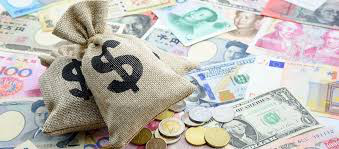

In [2]:
from PIL import Image
Image.open('images.jpg')

# Breif description of project

**Project Overview: Investigating the Impact of Foreign Direct Investment (FDI) on Economic Growth**

In our interconnected global economy, Foreign Direct Investment (FDI) plays a pivotal role in shaping national prosperity. Its impact extends far beyond financial transactions—it drives technology transfer, fuels job creation, expands markets, and even influences infrastructure development. Recognizing this significance, our project aims to delve into various FDI variables, including inflows, outflows, and netflows. However, our specific focus lies in analyzing the intricate relationship between FDI inflows and GDP growth.

**Objectives:**

1. **Variable Exploration:**
- We explore FDI inflows, outflows, GDP, and economic growth.
- Additionally, we analyze the percentage of GDP attributed to FDI.
2. **The FDI-GDP Nexus:**
- Our central focus lies in understanding how FDI inflows influence economic growth.
- To investigate this, we employ the Granger causality test—a statistical method that assesses whether past FDI values can predict future GDP growth.
3. **Data Source:**
- All our data originates from the World Bank, accessed via its API.
- Rigorous analysis ensures reliability and global relevance.

**FDI Variables (World Bank Definitions):**

- **Net Inflows:** The value of inward direct investment received by a reporting economy from non-resident investors.
- **Net Outflows:** The value of outward direct investment made by residents of the reporting economy in external economies.
- **Netflows:** Calculated as the difference between inflows and outflows. A positive figure indicates greater outflows, while a negative value reflects higher inflows.

# Importing libraries

In [6]:
#importing relevant libraries
import pandas as pd
import numpy as np
import wbgapi as wb
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
sns.set()
sns.set_style('white')
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
import matplotlib.ticker as ticker
import squarify
import textwrap
pd.options.display.float_format = '{:,.3f}'.format

# Importing and wrangling data

## Country data

In [9]:
#importing countries data
table = wb.economy.info()
table_dict = vars(table)

df_countries = pd.DataFrame(table_dict.get('items'))
df_countries

id                        value  aggregate  longitude  latitude region  \
0    ABW                        Aruba      False    -70.017    12.517    LCN   
1    AFE  Africa Eastern and Southern       True        NaN       NaN          
2    AFG                  Afghanistan      False     69.176    34.523    SAS   
3    AFW   Africa Western and Central       True        NaN       NaN          
4    AGO                       Angola      False     13.242    -8.812    SSF   
..   ...                          ...        ...        ...       ...    ...   
261  XKX                       Kosovo      False     20.926    42.565    ECS   
262  YEM                  Yemen, Rep.      False     44.208    15.352    MEA   
263  ZAF                 South Africa      False     28.187   -25.746    SSF   
264  ZMB                       Zambia      False     28.294   -15.398    SSF   
265  ZWE                     Zimbabwe      False     31.067   -17.831    SSF   

    adminregion lendingType incomeLevel capitalCity  
0                       LNX         HIC  Oranjestad  
1                                                    
2           SAS         IDX         LIC       Kabul  
3                                                    
4           SSA         IBD         LMC      Luanda  
..          ...         ...         ...         ...  
261         ECA         IDX         UMC    Pristina  
262         MNA         IDX         LIC      Sana'a  
263         SSA         IBD         UMC    Pretoria  
264         SSA         IDX         LMC      Lusaka  
265         SSA         IDB         LMC      Harare  

[266 rows x 10 columns]

In [10]:
#dropping unnecessary columns and aggregated regions, and renaming id and value columns
df_countries_clean = df_countries[df_countries['aggregate']==False]\
.drop(columns=['aggregate',
               'longitude',
               'latitude', 
               'adminregion',
               'lendingType',
               'capitalCity'],
      axis=1)\
.rename(columns={'id':'Country Code',
                 'value':'Country'})

df_countries_clean.head()

Country Code      Country region incomeLevel
0          ABW        Aruba    LCN         HIC
2          AFG  Afghanistan    SAS         LIC
4          AGO       Angola    SSF         LMC
5          ALB      Albania    ECS         UMC
6          AND      Andorra    ECS         HIC

In [11]:
#need to convert the abbreviations to full name in the region and incomeLevel columns
print('Checking the unique values in the region column')
print(df_countries_clean.incomeLevel.unique())
print('_____________________________')
print('Checking the unique values in the income level column')
print(df_countries_clean.region.unique())

Checking the unique values in the region column
['HIC' 'LIC' 'LMC' 'UMC' 'INX']
_____________________________
Checking the unique values in the income level column
['LCN' 'SAS' 'SSF' 'ECS' 'MEA' 'EAS' 'NAC']


In [12]:
#renaming the abbreviations of region and incomeLevel to the full name

#creating dictionaries that will be used to replace values in the region and incomeLevel columns
region_full = {'LCN':'Latin America & Caribbean', 
               'SAS':'South Asia', 
               'SSF':'Sub-Saharan Africa', 
               'ECS':'Europe & Central Asia', 
               'MEA':'Middle East & North Africa', 
               'EAS':'East Asia & Pacific', 
               'NAC':'North America'}

incomeLevel_full = {'HIC':'High income',
                    'LIC':'Low income', 
                    'LMC':'Lower middle income', 
                    'UMC':'Upper middle income', 
                    'INX':'Not classified'}

#replacing the region and income level values
df_countries_clean.region = df_countries_clean.region.replace(region_full)

df_countries_clean.incomeLevel = df_countries_clean.incomeLevel.replace(incomeLevel_full)

df_countries_clean.head()

Country Code      Country                     region          incomeLevel
0          ABW        Aruba  Latin America & Caribbean          High income
2          AFG  Afghanistan                 South Asia           Low income
4          AGO       Angola         Sub-Saharan Africa  Lower middle income
5          ALB      Albania      Europe & Central Asia  Upper middle income
6          AND      Andorra      Europe & Central Asia          High income

## FDI data

In [14]:
#checking the api code to use when importing the FDI data
wb.series.info(q='Foreign direct investment')

id                    value
--------------------  ----------------------------------------------------------
BM.KLT.DINV.CD.WD     Foreign direct investment, net outflows (BoP, current US$)
BM.KLT.DINV.WD.GD.ZS  Foreign direct investment, net outflows (% of GDP)
BN.KLT.DINV.CD        Foreign direct investment, net (BoP, current US$)
BX.KLT.DINV.CD.WD     Foreign direct investment, net inflows (BoP, current US$)
BX.KLT.DINV.WD.GD.ZS  Foreign direct investment, net inflows (% of GDP)
                      5 elements

In [15]:
#importing FDI data using world bank api - selecting time range from 1992 to 2022
df_fdi=wb.data.DataFrame(['BX.KLT.DINV.CD.WD', 
                          'BX.KLT.DINV.WD.GD.ZS',
                          'BM.KLT.DINV.CD.WD',
                          'BM.KLT.DINV.WD.GD.ZS',
                          'BN.KLT.DINV.CD'], 
                         time=range(1992, 2023)).reset_index()

df_fdi.head()

economy                series          YR1992          YR1993  \
0     ABW     BM.KLT.DINV.CD.WD   9,944,130.000   6,871,510.000   
1     ABW  BM.KLT.DINV.WD.GD.ZS           1.037           0.634   
2     ABW        BN.KLT.DINV.CD  36,983,240.223  17,932,960.894   
3     ABW     BX.KLT.DINV.CD.WD -36,983,240.223 -17,932,960.894   
4     ABW  BX.KLT.DINV.WD.GD.ZS          -3.858          -1.655   

           YR1994         YR1995          YR1996           YR1997  \
0   1,508,380.000  1,675,980.000     893,854.749      223,463.687   
1           0.121          0.127           0.065            0.015   
2  73,184,357.542  5,530,726.257 -84,134,078.212 -197,597,765.363   
3 -73,184,357.542 -5,530,726.257  85,027,932.961  197,821,229.050   
4          -5.874         -0.419           6.162           12.914   

           YR1998           YR1999  ...           YR2013           YR2014  \
0  31,284,916.201   -1,787,709.497  ...   49,214,590.245  -35,098,648.374   
1           1.879           -0.104  ...            1.804           -1.258   
2 -82,178,770.950 -469,329,608.939  ... -222,873,555.132 -243,442,685.619   
3 113,463,687.151  467,541,899.441  ...  272,088,145.377  208,344,037.245   
4           6.813           27.137  ...            9.974            7.465   

           YR2015          YR2016          YR2017           YR2018  \
0  10,319,084.567    -418,765.835  83,173,925.575   30,454,350.729   
1           0.348          -0.014           2.690            0.930   
2  37,200,481.561 -27,969,592.935 -79,282,916.727 -113,691,918.693   
3 -26,881,396.994  27,550,827.100 162,456,842.302  144,146,269.422   
4          -0.907           0.923           5.253            4.400   

           YR2019           YR2020           YR2021           YR2022  
0  59,757,863.331   20,043,217.061   -4,855,705.246  123,456,004.482  
1           1.760            0.783           -0.156            3.483  
2 134,984,404.015 -141,023,762.025 -138,400,826.425 -124,694,278.135  
3 -75,226,540.684  161,066,979.086  133,545,121.178  248,150,282.617  
4          -2.215            6.294            4.303            7.001  

[5 rows x 33 columns]

In [16]:
#replacing the series codes with the full name of the series
df_fdi.series = df_fdi.series.replace({'BM.KLT.DINV.CD.WD':'Foreign direct investment, net outflows (BoP, current US$)',
                                       'BM.KLT.DINV.WD.GD.ZS':'Foreign direct investment, net outflows (% of GDP)',
                                       'BN.KLT.DINV.CD':'Foreign direct investment, net (BoP, current US$)',
                                       'BX.KLT.DINV.CD.WD':'Foreign direct investment, net inflows (BoP, current US$)',
                                       'BX.KLT.DINV.WD.GD.ZS':'Foreign direct investment, net inflows (% of GDP)'})

df_fdi.head()

economy                                             series          YR1992  \
0     ABW  Foreign direct investment, net outflows (BoP, ...   9,944,130.000   
1     ABW  Foreign direct investment, net outflows (% of ...           1.037   
2     ABW  Foreign direct investment, net (BoP, current US$)  36,983,240.223   
3     ABW  Foreign direct investment, net inflows (BoP, c... -36,983,240.223   
4     ABW  Foreign direct investment, net inflows (% of GDP)          -3.858   

           YR1993          YR1994         YR1995          YR1996  \
0   6,871,510.000   1,508,380.000  1,675,980.000     893,854.749   
1           0.634           0.121          0.127           0.065   
2  17,932,960.894  73,184,357.542  5,530,726.257 -84,134,078.212   
3 -17,932,960.894 -73,184,357.542 -5,530,726.257  85,027,932.961   
4          -1.655          -5.874         -0.419           6.162   

            YR1997          YR1998           YR1999  ...           YR2013  \
0      223,463.687  31,284,916.201   -1,787,709.497  ...   49,214,590.245   
1            0.015           1.879           -0.104  ...            1.804   
2 -197,597,765.363 -82,178,770.950 -469,329,608.939  ... -222,873,555.132   
3  197,821,229.050 113,463,687.151  467,541,899.441  ...  272,088,145.377   
4           12.914           6.813           27.137  ...            9.974   

            YR2014          YR2015          YR2016          YR2017  \
0  -35,098,648.374  10,319,084.567    -418,765.835  83,173,925.575   
1           -1.258           0.348          -0.014           2.690   
2 -243,442,685.619  37,200,481.561 -27,969,592.935 -79,282,916.727   
3  208,344,037.245 -26,881,396.994  27,550,827.100 162,456,842.302   
4            7.465          -0.907           0.923           5.253   

            YR2018          YR2019           YR2020           YR2021  \
0   30,454,350.729  59,757,863.331   20,043,217.061   -4,855,705.246   
1            0.930           1.760            0.783           -0.156   
2 -113,691,918.693 134,984,404.015 -141,023,762.025 -138,400,826.425   
3  144,146,269.422 -75,226,540.684  161,066,979.086  133,545,121.178   
4            4.400          -2.215            6.294            4.303   

            YR2022  
0  123,456,004.482  
1            3.483  
2 -124,694,278.135  
3  248,150,282.617  
4            7.001  

[5 rows x 33 columns]

In [17]:
#unpivoting all the year columns so that there is a seprate column for the year and the fdi values

#creating list of the columns to unpivot
year_values=df_fdi.columns[:]

#unpivoting columns
df_fdi_unpivot = pd.melt(df_fdi, 
                         id_vars=['economy', 'series'], 
                         value_vars=year_values, 
                         var_name='Year', 
                         value_name='values')

#removing YR poart on all the year strings and converting coloumn to int
df_fdi_unpivot.Year = df_fdi_unpivot.Year.str.replace('YR','').apply(lambda x: int(x))

df_fdi_unpivot.head()

economy                                             series  Year  \
0     ABW  Foreign direct investment, net outflows (BoP, ...  1992   
1     ABW  Foreign direct investment, net outflows (% of ...  1992   
2     ABW  Foreign direct investment, net (BoP, current US$)  1992   
3     ABW  Foreign direct investment, net inflows (BoP, c...  1992   
4     ABW  Foreign direct investment, net inflows (% of GDP)  1992   

           values  
0   9,944,130.000  
1           1.037  
2  36,983,240.223  
3 -36,983,240.223  
4          -3.858

In [18]:
#pivoting the series column so that each fdi variable is its own column
df_fdi_pivot = df_fdi_unpivot.pivot(index=['economy','Year'],
                                    columns='series',
                                    values='values')\
.reset_index()\
.rename(columns={'economy':'Country Code'})

df_fdi_pivot.head()

series Country Code  Year  Foreign direct investment, net (BoP, current US$)  \
0               ABW  1992                                     36,983,240.223   
1               ABW  1993                                     17,932,960.894   
2               ABW  1994                                     73,184,357.542   
3               ABW  1995                                      5,530,726.257   
4               ABW  1996                                    -84,134,078.212   

series  Foreign direct investment, net inflows (% of GDP)  \
0                                                  -3.858   
1                                                  -1.655   
2                                                  -5.874   
3                                                  -0.419   
4                                                   6.162   

series  Foreign direct investment, net inflows (BoP, current US$)  \
0                                         -36,983,240.223           
1                                         -17,932,960.894           
2                                         -73,184,357.542           
3                                          -5,530,726.257           
4                                          85,027,932.961           

series  Foreign direct investment, net outflows (% of GDP)  \
0                                                   1.037    
1                                                   0.634    
2                                                   0.121    
3                                                   0.127    
4                                                   0.065    

series  Foreign direct investment, net outflows (BoP, current US$)  
0                                           9,944,130.000           
1                                           6,871,510.000           
2                                           1,508,380.000           
3                                           1,675,980.000           
4                                             893,854.749

In [19]:
#merging the country dataframe with the fdi dataframe
df_fdi_final = pd.merge(df_countries_clean,
                        df_fdi_pivot,
                        how='inner',
                        left_on='Country Code', 
                        right_on='Country Code')

df_fdi_final.head()

Country Code Country                     region  incomeLevel  Year  \
0          ABW   Aruba  Latin America & Caribbean  High income  1992   
1          ABW   Aruba  Latin America & Caribbean  High income  1993   
2          ABW   Aruba  Latin America & Caribbean  High income  1994   
3          ABW   Aruba  Latin America & Caribbean  High income  1995   
4          ABW   Aruba  Latin America & Caribbean  High income  1996   

   Foreign direct investment, net (BoP, current US$)  \
0                                     36,983,240.223   
1                                     17,932,960.894   
2                                     73,184,357.542   
3                                      5,530,726.257   
4                                    -84,134,078.212   

   Foreign direct investment, net inflows (% of GDP)  \
0                                             -3.858   
1                                             -1.655   
2                                             -5.874   
3                                             -0.419   
4                                              6.162   

   Foreign direct investment, net inflows (BoP, current US$)  \
0                                    -36,983,240.223           
1                                    -17,932,960.894           
2                                    -73,184,357.542           
3                                     -5,530,726.257           
4                                     85,027,932.961           

   Foreign direct investment, net outflows (% of GDP)  \
0                                              1.037    
1                                              0.634    
2                                              0.121    
3                                              0.127    
4                                              0.065    

   Foreign direct investment, net outflows (BoP, current US$)  
0                                      9,944,130.000           
1                                      6,871,510.000           
2                                      1,508,380.000           
3                                      1,675,980.000           
4                                        893,854.749

In [20]:
#checking on data types
df_fdi_final.dtypes #all data types are fine

Country Code                                                   object
Country                                                        object
region                                                         object
incomeLevel                                                    object
Year                                                            int64
Foreign direct investment, net (BoP, current US$)             float64
Foreign direct investment, net inflows (% of GDP)             float64
Foreign direct investment, net inflows (BoP, current US$)     float64
Foreign direct investment, net outflows (% of GDP)            float64
Foreign direct investment, net outflows (BoP, current US$)    float64
dtype: object

## GDP data


In [22]:
#checking the api code to use when importing the gdp data
wb.series.info(q='GDP') #will only be taking GDP (constant 2015) and GDP growth annual

id                    value
--------------------  -------------------------------------------------------------------------
EG.GDP.PUSE.KO.PP     GDP per unit of energy use (PPP $ per kg of oil equivalent)
EG.GDP.PUSE.KO.PP.KD  GDP per unit of energy use (constant 2021 PPP $ per kg of oil equivalent)
EG.USE.COMM.GD.PP.KD  Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)
NY.GDP.DEFL.KD.ZG     Inflation, GDP deflator (annual %)
NY.GDP.DEFL.KD.ZG.AD  Inflation, GDP deflator: linked series (annual %)
NY.GDP.DEFL.ZS        GDP deflator (base year varies by country)
NY.GDP.DEFL.ZS.AD     GDP deflator: linked series (base year varies by country)
NY.GDP.DISC.CN        Discrepancy in expenditure estimate of GDP (current LCU)
NY.GDP.DISC.KN        Discrepancy in expenditure estimate of GDP (constant LCU)
NY.GDP.MKTP.CD        GDP (current US$)
NY.GDP.MKTP.CN        GDP (current LCU)
NY.GDP.MKTP.CN.AD     GDP: linked series (current LCU)
NY.GDP.MKTP.KD        GDP (constant 2015 US$)
NY.GDP.MKTP.KD.ZG     GDP growth (annual %)
NY.GDP.MKTP.KN        GDP (constant LCU)
NY.GDP.MKTP.PP.CD     GDP, PPP (current international $)
NY.GDP.MKTP.PP.KD     GDP, PPP (constant 2021 international $)
NY.GDP.PCAP.CD        GDP per capita (current US$)
NY.GDP.PCAP.CN        GDP per capita (current LCU)
NY.GDP.PCAP.KD        GDP per capita (constant 2015 US$)
NY.GDP.PCAP.KD.ZG     GDP per capita growth (annual %)
NY.GDP.PCAP.KN        GDP per capita (constant LCU)
NY.GDP.PCAP.PP.CD     GDP per capita, PPP (current international $)
NY.GDP.PCAP.PP.KD     GDP per capita, PPP (constant 2021 international $)
PA.NUS.PPP            PPP conversion factor, GDP (LCU per international $)
PA.NUS.PPPC.RF        Price level ratio of PPP conversion factor (GDP) to market exchange rate
SL.GDP.PCAP.EM.KD     GDP per person employed (constant 2021 PPP $)
                      27 elements

In [23]:
#importing real GDP data and Real GDP growth data using world bank api - selecting time range from 1992 to 2022
df_gdp=wb.data.DataFrame(['NY.GDP.MKTP.KD',
                          'NY.GDP.MKTP.KD.ZG'], 
                         time=range(1992, 2023)).reset_index()
df_gdp

economy             series              YR1992              YR1993  \
0       ABW     NY.GDP.MKTP.KD   1,908,830,345.976   2,048,321,812.233   
1       ABW  NY.GDP.MKTP.KD.ZG               5.882               7.308   
2       AFE     NY.GDP.MKTP.KD 390,374,495,346.735 388,065,113,583.224   
3       AFE  NY.GDP.MKTP.KD.ZG              -2.355              -0.592   
4       AFG     NY.GDP.MKTP.KD                 NaN                 NaN   
..      ...                ...                 ...                 ...   
527     ZAF  NY.GDP.MKTP.KD.ZG              -2.137               1.234   
528     ZMB     NY.GDP.MKTP.KD   6,720,005,310.133   7,176,782,487.175   
529     ZMB  NY.GDP.MKTP.KD.ZG              -1.731               6.797   
530     ZWE     NY.GDP.MKTP.KD  16,009,469,333.076  16,177,802,282.753   
531     ZWE  NY.GDP.MKTP.KD.ZG              -9.016               1.051   

                 YR1994              YR1995              YR1996  \
0     2,216,364,111.874   2,272,818,090.432   2,299,768,906.232   
1                 8.204               2.547               1.186   
2   395,434,537,181.729 412,371,762,037.557 434,865,700,351.801   
3                 1.899               4.283               5.455   
4                   NaN                 NaN                 NaN   
..                  ...                 ...                 ...   
527               3.200               3.100               4.300   
528   6,557,753,279.700   6,747,775,256.593   7,167,388,797.894   
529              -8.625               2.898               6.219   
530  17,671,854,489.114  17,699,780,558.608  19,533,601,150.580   
531               9.235               0.158              10.361   

                 YR1997              YR1998              YR1999  ...  \
0     2,461,830,746.169   2,510,870,031.795   2,541,955,653.388  ...   
1                 7.047               1.992               1.238  ...   
2   451,559,227,208.536 459,499,329,803.337 471,703,443,866.977  ...   
3                 3.839               1.758               2.656  ...   
4                   NaN                 NaN                 NaN  ...   
..                  ...                 ...                 ...  ...   
527               2.600               0.500               2.400  ...   
528   7,440,753,543.998   7,412,051,123.984   7,756,725,565.347  ...   
529               3.814              -0.386               4.650  ...   
530  20,057,217,725.916  20,635,910,937.733  20,467,146,117.723  ...   
531               2.681               2.885              -0.818  ...   

                 YR2013              YR2014              YR2015  \
0     3,029,567,030.344   2,981,500,673.046   2,962,907,262.570   
1                 6.431              -1.587              -0.624   
2   839,563,188,665.822 873,004,516,663.327 899,295,676,086.836   
3                 4.250               3.983               3.012   
4    18,360,263,162.758  18,860,496,494.040  19,134,221,644.732   
..                  ...                 ...                 ...   
527               2.485               1.414               1.322   
528  19,722,575,258.931  20,648,211,567.062  21,251,216,798.776   
529               5.058               4.693               2.920   
530  19,280,916,546.449  19,567,149,970.420  19,963,120,600.000   
531               3.197               1.485               2.024   

                 YR2016              YR2017              YR2018  \
0     3,013,858,155.988   3,226,290,954.321   3,303,132,499.880   
1                 1.720               7.049               2.382   
2   918,932,523,633.942 943,297,098,194.971 968,593,667,253.301   
3                 2.184               2.651               2.682   
4    19,566,715,174.163  20,084,646,751.495  20,323,499,020.364   
..                  ...                 ...                 ...   
527               0.665               1.158               1.557   
528  22,049,221,308.357  22,826,646,593.617  23,747,586,257.251   
529               3.755              

In [24]:
#replacing the series codes with the full name of the series
df_gdp.series = df_gdp.series.replace({'NY.GDP.MKTP.KD':'GDP (constant 2015 US$)',
                                       'NY.GDP.MKTP.KD.ZG':'GDP growth (annual %)'})

df_gdp.head()

economy                   series              YR1992              YR1993  \
0     ABW  GDP (constant 2015 US$)   1,908,830,345.976   2,048,321,812.233   
1     ABW    GDP growth (annual %)               5.882               7.308   
2     AFE  GDP (constant 2015 US$) 390,374,495,346.735 388,065,113,583.224   
3     AFE    GDP growth (annual %)              -2.355              -0.592   
4     AFG  GDP (constant 2015 US$)                 NaN                 NaN   

               YR1994              YR1995              YR1996  \
0   2,216,364,111.874   2,272,818,090.432   2,299,768,906.232   
1               8.204               2.547               1.186   
2 395,434,537,181.729 412,371,762,037.557 434,865,700,351.801   
3               1.899               4.283               5.455   
4                 NaN                 NaN                 NaN   

               YR1997              YR1998              YR1999  ...  \
0   2,461,830,746.169   2,510,870,031.795   2,541,955,653.388  ...   
1               7.047               1.992               1.238  ...   
2 451,559,227,208.536 459,499,329,803.337 471,703,443,866.977  ...   
3               3.839               1.758               2.656  ...   
4                 NaN                 NaN                 NaN  ...   

               YR2013              YR2014              YR2015  \
0   3,029,567,030.344   2,981,500,673.046   2,962,907,262.570   
1               6.431              -1.587              -0.624   
2 839,563,188,665.822 873,004,516,663.327 899,295,676,086.836   
3               4.250               3.983               3.012   
4  18,360,263,162.758  18,860,496,494.040  19,134,221,644.732   

               YR2016              YR2017              YR2018  \
0   3,013,858,155.988   3,226,290,954.321   3,303,132,499.880   
1               1.720               7.049               2.382   
2 918,932,523,633.942 943,297,098,194.971 968,593,667,253.301   
3               2.184               2.651               2.682   
4  19,566,715,174.163  20,084,646,751.495  20,323,499,020.364   

               YR2019              YR2020                YR2021  \
0   3,227,066,765.545   2,453,132,865.874     3,131,163,015.594   
1              -2.303             -23.983                27.639   
2 989,798,694,036.450 962,278,543,441.163 1,005,555,866,031.160   
3               2.189              -2.780                 4.497   
4  21,118,473,702.347  20,621,957,125.208    16,345,202,562.549   

                 YR2022  
0     3,458,629,980.618  
1                10.458  
2 1,041,297,568,267.860  
3                 3.554  
4    15,325,233,810.139  

[5 rows x 33 columns]

In [25]:
#unpivoting all the year columns

#creating list of the columns to unpivot
year_values = df_gdp.columns[:]

#unpivoting columns
df_gdp_unpivot = pd.melt(df_gdp, 
                         id_vars=['economy', 'series'], 
                         value_vars=year_values, 
                         var_name='Year', 
                         value_name='values')

#removing YR on all the year strings and converting coloumn to int
df_gdp_unpivot.Year = df_gdp_unpivot.Year.str.replace('YR','').apply(lambda x: int(x))

df_gdp_unpivot.head()

economy                   series  Year              values
0     ABW  GDP (constant 2015 US$)  1992   1,908,830,345.976
1     ABW    GDP growth (annual %)  1992               5.882
2     AFE  GDP (constant 2015 US$)  1992 390,374,495,346.735
3     AFE    GDP growth (annual %)  1992              -2.355
4     AFG  GDP (constant 2015 US$)  1992                 NaN

In [26]:
#pivoting the series column so that each gdp variable has its own column
df_gdp_pivot = df_gdp_unpivot.pivot(index=['economy','Year'],
                                    columns='series',
                                    values='values')\
.reset_index()\
.rename(columns={'economy':'Country Code'})

df_gdp_pivot.head()

series Country Code  Year  GDP (constant 2015 US$)  GDP growth (annual %)
0               ABW  1992        1,908,830,345.976                  5.882
1               ABW  1993        2,048,321,812.233                  7.308
2               ABW  1994        2,216,364,111.874                  8.204
3               ABW  1995        2,272,818,090.432                  2.547
4               ABW  1996        2,299,768,906.232                  1.186

In [27]:
#merging fdi and gdp data
df_fdi_gdp = pd.merge(df_fdi_final,
                      df_gdp_pivot, 
                      how='inner',
                      left_on=['Country Code','Year'],
                      right_on=['Country Code','Year'])

df_fdi_gdp.head()

Country Code Country                     region  incomeLevel  Year  \
0          ABW   Aruba  Latin America & Caribbean  High income  1992   
1          ABW   Aruba  Latin America & Caribbean  High income  1993   
2          ABW   Aruba  Latin America & Caribbean  High income  1994   
3          ABW   Aruba  Latin America & Caribbean  High income  1995   
4          ABW   Aruba  Latin America & Caribbean  High income  1996   

   Foreign direct investment, net (BoP, current US$)  \
0                                     36,983,240.223   
1                                     17,932,960.894   
2                                     73,184,357.542   
3                                      5,530,726.257   
4                                    -84,134,078.212   

   Foreign direct investment, net inflows (% of GDP)  \
0                                             -3.858   
1                                             -1.655   
2                                             -5.874   
3                                             -0.419   
4                                              6.162   

   Foreign direct investment, net inflows (BoP, current US$)  \
0                                    -36,983,240.223           
1                                    -17,932,960.894           
2                                    -73,184,357.542           
3                                     -5,530,726.257           
4                                     85,027,932.961           

   Foreign direct investment, net outflows (% of GDP)  \
0                                              1.037    
1                                              0.634    
2                                              0.121    
3                                              0.127    
4                                              0.065    

   Foreign direct investment, net outflows (BoP, current US$)  \
0                                      9,944,130.000            
1                                      6,871,510.000            
2                                      1,508,380.000            
3                                      1,675,980.000            
4                                        893,854.749            

   GDP (constant 2015 US$)  GDP growth (annual %)  
0        1,908,830,345.976                  5.882  
1        2,048,321,812.233                  7.308  
2        2,216,364,111.874                  8.204  
3        2,272,818,090.432                  2.547  
4        2,299,768,906.232                  1.186

In [28]:
#checking number of countries that are in the data set
df_fdi_gdp.Country.nunique()

217

There are 217 countries and/or territories in the dataframe.

In [30]:
#checking for null values
df_fdi_gdp.isnull().sum()

Country Code                                                     0
Country                                                          0
region                                                           0
incomeLevel                                                      0
Year                                                             0
Foreign direct investment, net (BoP, current US$)             1558
Foreign direct investment, net inflows (% of GDP)              906
Foreign direct investment, net inflows (BoP, current US$)      814
Foreign direct investment, net outflows (% of GDP)            2050
Foreign direct investment, net outflows (BoP, current US$)    1985
GDP (constant 2015 US$)                                        465
GDP growth (annual %)                                          417
dtype: int64

There are a significant number of null values in the data. Therefore, we will investigate the percentage of null values for each country. If a country has more than 20% of null values it will be dropped from the dataset. Otherwise, the null values will be filled with the median value

In [32]:
#creating a dataframe that summaries the percentage of missing values of the variables to be analysed

#creating list of countries and empty list
country_list = list(df_fdi_gdp['Country'].unique())
series_list = []
n = 12

#creating a loop to iterate through each country creating a series of the summarised\
#missing data then creating a dataframe
for i in country_list:
    country_filter = list(df_fdi_gdp\
                        .loc[(df_fdi_gdp['Country']==i)]\
                        .isnull()\
                        .sum() / len(df_fdi_gdp\
                                     .loc[(df_fdi_gdp['Country']==i)])*100)
    for j in country_filter:
        series_list.append(j)
        sublists = [series_list[i:i+n] for i in range(0,len(series_list),n)]
        df_null_values_pct = pd.DataFrame(sublists)

In [33]:
df_null_values_pct

0     1     2     3     4      5       6       7       8       9   \
0   0.000 0.000 0.000 0.000 0.000  0.000   0.000   0.000   0.000   0.000   
1   0.000 0.000 0.000 0.000 0.000 58.065  29.032   3.226  45.161  45.161   
2   0.000 0.000 0.000 0.000 0.000  0.000   3.226   0.000  12.903   9.677   
3   0.000 0.000 0.000 0.000 0.000  0.000   0.000   0.000  38.710  38.710   
4   0.000 0.000 0.000 0.000 0.000 87.097 100.000 100.000 100.000 100.000   
..    ...   ...   ...   ...   ...    ...     ...     ...     ...     ...   
212 0.000 0.000 0.000 0.000 0.000 38.710  51.613  38.710  51.613  38.710   
213 0.000 0.000 0.000 0.000 0.000 61.290   9.677   9.677  12.903  12.903   
214 0.000 0.000 0.000 0.000 0.000  0.000   0.000   0.000   0.000   0.000   
215 0.000 0.000 0.000 0.000 0.000 16.129   0.000   0.000  51.613  51.613   
216 0.000 0.000 0.000 0.000 0.000 51.613   0.000   0.000   3.226   3.226   

        10     11  
0    0.000  0.000  
1   25.806 29.032  
2    0.000  0.000  
3    0.000  0.000  
4    0.000  0.000  
..     ...    ...  
212 51.613 54.839  
213 12.903 12.903  
214  0.000  0.000  
215  0.000  0.000  
216  0.000  0.000  

[217 rows x 12 columns]

In [34]:
#renaming the index and the columns of the dataframe
columns = list(df_fdi_gdp\
               .loc[(df_fdi_gdp['Country']=='Aruba')]\
               .isnull()\
               .sum()\
               .index)

df_null_values_pct.index = country_list
df_null_values_pct.columns = columns

df_null_values_pct.head()

Country Code  Country  region  incomeLevel  Year  \
Aruba               0.000    0.000   0.000        0.000 0.000   
Afghanistan         0.000    0.000   0.000        0.000 0.000   
Angola              0.000    0.000   0.000        0.000 0.000   
Albania             0.000    0.000   0.000        0.000 0.000   
Andorra             0.000    0.000   0.000        0.000 0.000   

             Foreign direct investment, net (BoP, current US$)  \
Aruba                                                    0.000   
Afghanistan                                             58.065   
Angola                                                   0.000   
Albania                                                  0.000   
Andorra                                                 87.097   

             Foreign direct investment, net inflows (% of GDP)  \
Aruba                                                    0.000   
Afghanistan                                             29.032   
Angola                                                   3.226   
Albania                                                  0.000   
Andorra                                                100.000   

             Foreign direct investment, net inflows (BoP, current US$)  \
Aruba                                                    0.000           
Afghanistan                                              3.226           
Angola                                                   0.000           
Albania                                                  0.000           
Andorra                                                100.000           

             Foreign direct investment, net outflows (% of GDP)  \
Aruba                                                    0.000    
Afghanistan                                             45.161    
Angola                                                  12.903    
Albania                                                 38.710    
Andorra                                                100.000    

             Foreign direct investment, net outflows (BoP, current US$)  \
Aruba                                                    0.000            
Afghanistan                                             45.161            
Angola                                                   9.677            
Albania                                                 38.710            
Andorra                                                100.000            

             GDP (constant 2015 US$)  GDP growth (annual %)  
Aruba                          0.000                  0.000  
Afghanistan                   25.806                 29.032  
Angola                         0.000                  0.000  
Albania                        0.000                  0.000  
Andorra                        0.000                  0.000

In [35]:
#testing that the loop worked correctly by selecting a country
print(df_fdi_gdp\
.loc[(df_fdi_gdp['Country']=='Afghanistan')]\
.isnull()\
.sum()/len(df_fdi_gdp\
             .loc[(df_fdi_gdp['Country']=='Afghanistan')]) *100)

print('_____________________________________________________________________________')

print(df_null_values_pct.filter(like='Afghanistan', axis=0).T)

#the loop worked correctly👍🫡

Country Code                                                  0.000
Country                                                       0.000
region                                                        0.000
incomeLevel                                                   0.000
Year                                                          0.000
Foreign direct investment, net (BoP, current US$)            58.065
Foreign direct investment, net inflows (% of GDP)            29.032
Foreign direct investment, net inflows (BoP, current US$)     3.226
Foreign direct investment, net outflows (% of GDP)           45.161
Foreign direct investment, net outflows (BoP, current US$)   45.161
GDP (constant 2015 US$)                                      25.806
GDP growth (annual %)                                        29.032
dtype: float64
_____________________________________________________________________________
                                                    Afghanistan
Country Code               

In [36]:
#list of countries to drop that have more than 20% of missing data
countries_to_drop = \
list(df_null_values_pct[(df_null_values_pct['Foreign direct investment, net inflows (% of GDP)']>20) |\
                        (df_null_values_pct['Foreign direct investment, net inflows (BoP, current US$)']>20) |\
                        (df_null_values_pct['Foreign direct investment, net outflows (% of GDP)']>20) |\
                        (df_null_values_pct['Foreign direct investment, net outflows (BoP, current US$)']>20) |\
                        (df_null_values_pct['GDP (constant 2015 US$)']>20) |\
                        (df_null_values_pct['GDP growth (annual %)']>20)].index)

print(countries_to_drop)
print(str(len(countries_to_drop)) + ' countries will be dropped')

['Afghanistan', 'Albania', 'Andorra', 'Armenia', 'American Samoa', 'Antigua and Barbuda', 'Burundi', 'Bosnia and Herzegovina', 'Brunei Darussalam', 'Bhutan', 'Central African Republic', 'Channel Islands', 'Comoros', 'Cuba', 'Curacao', 'Cayman Islands', 'Djibouti', 'Dominica', 'Ecuador', 'Eritrea', 'Ethiopia', 'Faroe Islands', 'Micronesia, Fed. Sts.', 'Georgia', 'Gibraltar', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea', 'Grenada', 'Greenland', 'Guam', 'Guyana', 'Haiti', 'Isle of Man', 'Iraq', 'Kyrgyz Republic', 'St. Kitts and Nevis', 'Libya', 'St. Lucia', 'Liechtenstein', 'Lesotho', 'Luxembourg', 'Macao SAR, China', 'St. Martin (French part)', 'Monaco', 'Maldives', 'Marshall Islands', 'Myanmar', 'Montenegro', 'Mongolia', 'Northern Mariana Islands', 'Mozambique', 'Mauritania', 'New Caledonia', 'Nicaragua', 'Nepal', 'Nauru', 'Oman', 'Palau', 'Puerto Rico', "Korea, Dem. People's Rep.", 'Rwanda', 'Sudan', 'Solomon Islands', 'Sierra Leone', 'San Marino', 'Somalia', 'Serbia', 'South Su

In [37]:
#dropping the countries that have more than 20 percent of missing data
df_fdi_gdp_final = df_fdi_gdp\
[~df_fdi_gdp\
 ['Country']\
 .isin(countries_to_drop)]

In [38]:
df_fdi_gdp_final.Country.nunique()

125

126 countries are left in the dataframe

In [40]:
#creating a table to show the number of countries before nulls are dropped and after nulls are dropped 
before_index0 = df_fdi_gdp.groupby('region')['Country'].nunique().index[0]
before_index1 = df_fdi_gdp.groupby('region')['Country'].nunique().index[1]
before_index2 = df_fdi_gdp.groupby('region')['Country'].nunique().index[2]
before_index3 = df_fdi_gdp.groupby('region')['Country'].nunique().index[3]
before_index4 = df_fdi_gdp.groupby('region')['Country'].nunique().index[4]
before_index5 = df_fdi_gdp.groupby('region')['Country'].nunique().index[5]
before_index6 = df_fdi_gdp.groupby('region')['Country'].nunique().index[6]

after_index0 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[0]
after_index1 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[1]
after_index2 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[2]
after_index3 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[3]
after_index4 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[4]
after_index5 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[5]
after_index6 = df_fdi_gdp_final.groupby('region')['Country'].nunique().index[6]


before_value0=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[0]
before_value1=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[1]
before_value2=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[2]
before_value3=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[3]
before_value4=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[4]
before_value5=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[5]
before_value6=df_fdi_gdp.groupby('region')['Country'].nunique().iloc[6]

after_value0=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[0]
after_value1=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[1]
after_value2=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[2]
after_value3=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[3]
after_value4=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[4]
after_value5=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[5]
after_value6=df_fdi_gdp_final.groupby('region')['Country'].nunique().iloc[6]

table = []
table.append(['Region','No. of countries before removing null values','No. of countries after removing null values'])
table.append([before_index0,before_value0,after_value0])
table.append([before_index1,before_value1,after_value1])
table.append([before_index2,before_value2,after_value2])
table.append([before_index3,before_value3,after_value3])
table.append([before_index4,before_value4,after_value4])
table.append([before_index5,before_value5,after_value5])
table.append([before_index6,before_value6,after_value6])
table.append(['Total countries',df_fdi_gdp.groupby('region')['Country'].nunique().sum(),df_fdi_gdp_final.groupby('region')['Country'].nunique().sum()])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════════════════════════╤════════════════════════════════════════════════╤═══════════════════════════════════════════════╕
│ Region                     │   No. of countries before removing null values │   No. of countries after removing null values │
╞════════════════════════════╪════════════════════════════════════════════════╪═══════════════════════════════════════════════╡
│ East Asia & Pacific        │                                             37 │                                            18 │
├────────────────────────────┼────────────────────────────────────────────────┼───────────────────────────────────────────────┤
│ Europe & Central Asia      │                                             58 │                                            37 │
├────────────────────────────┼────────────────────────────────────────────────┼───────────────────────────────────────────────┤
│ Latin America & Caribbean  │                                             42 │                         

In [41]:
#checking null values
df_fdi_gdp_final.isnull().sum()

Country Code                                                    0
Country                                                         0
region                                                          0
incomeLevel                                                     0
Year                                                            0
Foreign direct investment, net (BoP, current US$)             332
Foreign direct investment, net inflows (% of GDP)              28
Foreign direct investment, net inflows (BoP, current US$)      19
Foreign direct investment, net outflows (% of GDP)            131
Foreign direct investment, net outflows (BoP, current US$)    125
GDP (constant 2015 US$)                                         6
GDP growth (annual %)                                           7
dtype: int64

Null values for FDI net outflows and inflows and gdp will be filled using the median for each country. Null values for FDI net will be calculated by subtracting FDI inflows from outflows

In [43]:
#filling in remaining null values
df_fdi_gdp_final[['Foreign direct investment, net inflows (% of GDP)',
                  'Foreign direct investment, net inflows (BoP, current US$)',
                  'Foreign direct investment, net outflows (% of GDP)',
                  'Foreign direct investment, net outflows (BoP, current US$)',
                  'GDP (constant 2015 US$)', 
                  'GDP growth (annual %)']] = \
df_fdi_gdp_final.groupby('Country')[['Foreign direct investment, net inflows (% of GDP)',
                                     'Foreign direct investment, net inflows (BoP, current US$)',
                                     'Foreign direct investment, net outflows (% of GDP)',
                                     'Foreign direct investment, net outflows (BoP, current US$)',
                                     'GDP (constant 2015 US$)',
                                     'GDP growth (annual %)']]\
.transform(lambda x: x.fillna(x.median()))

df_fdi_gdp_final['Foreign direct investment, net (BoP, current US$)'] = \
df_fdi_gdp_final['Foreign direct investment, net (BoP, current US$)']\
.fillna(df_fdi_gdp_final['Foreign direct investment, net outflows (BoP, current US$)']\
        -df_fdi_gdp_final['Foreign direct investment, net inflows (BoP, current US$)'])


In [44]:
#checking that all null values have been filled
df_fdi_gdp_final.isnull().sum() # all null values filled

Country Code                                                  0
Country                                                       0
region                                                        0
incomeLevel                                                   0
Year                                                          0
Foreign direct investment, net (BoP, current US$)             0
Foreign direct investment, net inflows (% of GDP)             0
Foreign direct investment, net inflows (BoP, current US$)     0
Foreign direct investment, net outflows (% of GDP)            0
Foreign direct investment, net outflows (BoP, current US$)    0
GDP (constant 2015 US$)                                       0
GDP growth (annual %)                                         0
dtype: int64

In [45]:
#checking if there are duplicate values
df_fdi_gdp_final.duplicated().sum() # no duplicate values

0

In [46]:
#adjusting the scale of the US$ columns to millions to make the numbers easier to read as they are large
df_fdi_gdp_final[['Foreign direct investment, net (BoP, current US$)',
                  'Foreign direct investment, net inflows (BoP, current US$)',
                  'Foreign direct investment, net outflows (BoP, current US$)',
                  'GDP (constant 2015 US$)']] = \
df_fdi_gdp_final[['Foreign direct investment, net (BoP, current US$)',
                  'Foreign direct investment, net inflows (BoP, current US$)',
                  'Foreign direct investment, net outflows (BoP, current US$)',
                  'GDP (constant 2015 US$)']].div(1000000)

df_fdi_gdp_final.head()

Country Code Country                     region  incomeLevel  Year  \
0          ABW   Aruba  Latin America & Caribbean  High income  1992   
1          ABW   Aruba  Latin America & Caribbean  High income  1993   
2          ABW   Aruba  Latin America & Caribbean  High income  1994   
3          ABW   Aruba  Latin America & Caribbean  High income  1995   
4          ABW   Aruba  Latin America & Caribbean  High income  1996   

   Foreign direct investment, net (BoP, current US$)  \
0                                             36.983   
1                                             17.933   
2                                             73.184   
3                                              5.531   
4                                            -84.134   

   Foreign direct investment, net inflows (% of GDP)  \
0                                             -3.858   
1                                             -1.655   
2                                             -5.874   
3                                             -0.419   
4                                              6.162   

   Foreign direct investment, net inflows (BoP, current US$)  \
0                                            -36.983           
1                                            -17.933           
2                                            -73.184           
3                                             -5.531           
4                                             85.028           

   Foreign direct investment, net outflows (% of GDP)  \
0                                              1.037    
1                                              0.634    
2                                              0.121    
3                                              0.127    
4                                              0.065    

   Foreign direct investment, net outflows (BoP, current US$)  \
0                                              9.944            
1                                              6.872            
2                                              1.508            
3                                              1.676            
4                                              0.894            

   GDP (constant 2015 US$)  GDP growth (annual %)  
0                1,908.830                  5.882  
1                2,048.322                  7.308  
2                2,216.364                  8.204  
3                2,272.818                  2.547  
4                2,299.769                  1.186

The final combined dataframe with FDI and GDP values is now clean

# Exploratory data analysis

## Descriptive statistic

We will examine descriptive statistics based on income levels.

### High income economies

In [52]:
df_fdi_gdp_final[df_fdi_gdp_final['incomeLevel']=='High income'].describe()

Year  Foreign direct investment, net (BoP, current US$)  \
count 1,674.000                                          1,674.000   
mean  2,007.000                                          3,080.207   
std       8.947                                         31,219.959   
min   1,992.000                                       -345,435.000   
25%   1,999.000                                         -2,445.728   
50%   2,007.000                                           -252.939   
75%   2,015.000                                          2,606.046   
max   2,022.000                                        218,323.781   

       Foreign direct investment, net inflows (% of GDP)  \
count                                          1,674.000   
mean                                               6.631   
std                                               23.472   
min                                             -103.157   
25%                                                0.989   
50%                                                2.687   
75%                                                5.731   
max                                              449.083   

       Foreign direct investment, net inflows (BoP, current US$)  \
count                                          1,674.000           
mean                                          19,578.359           
std                                           55,301.699           
min                                         -286,149.009           
25%                                              382.455           
50%                                            3,233.475           
75%                                           15,711.440           
max                                          733,826.502           

       Foreign direct investment, net outflows (% of GDP)  \
count                                          1,674.000    
mean                                               4.363    
std                                               20.464    
min                                             -137.317    
25%                                                0.277    
50%                                                1.408    
75%                                                3.815    
max                                              300.421    

       Foreign direct investment, net outflows (BoP, current US$)  \
count                                          1,674.000            
mean                                          22,672.617            
std                                           60,783.122            
min                                         -268,227.774            
25%                                               43.121            
50%                                            1,755.569            
75%                                           18,502.271            
max                                          596,418.054            

       GDP (constant 2015 US$)  GDP growth (annual %)  
count                1,674.000              1,674.000  
mean               784,753.415                  2.780  
std              2,251,749.538                  4.865  
min                    672.090                -32.119  
25%                 31,748.416                  1.067  
50%                180,653.261                  2.792  
75%                505,158.454                  4.750  
max             21,236,308.982                 82.809

### Upper middle income economies

In [54]:
df_fdi_gdp_final[df_fdi_gdp_final['incomeLevel']=='Upper middle income'].describe()

Year  Foreign direct investment, net (BoP, current US$)  \
count   992.000                                            992.000   
mean  2,007.000                                         -5,744.378   
std       8.949                                         19,463.976   
min   1,992.000                                       -231,651.578   
25%   1,999.000                                         -3,453.173   
50%   2,007.000                                           -699.653   
75%   2,015.000                                           -113.421   
max   2,022.000                                         41,674.876   

       Foreign direct investment, net inflows (% of GDP)  \
count                                            992.000   
mean                                               3.203   
std                                                4.064   
min                                               -7.596   
25%                                                1.246   
50%                                                2.488   
75%                                                4.251   
max                                               55.073   

       Foreign direct investment, net inflows (BoP, current US$)  \
count                                            992.000           
mean                                           8,962.392           
std                                           31,029.008           
min                                           -4,947.474           
25%                                              202.400           
50%                                              937.240           
75%                                            4,983.002           
max                                          344,074.977           

       Foreign direct investment, net outflows (% of GDP)  \
count                                            992.000    
mean                                               0.741    
std                                                2.388    
min                                               -7.563    
25%                                                0.036    
50%                                                0.258    
75%                                                0.779    
max                                               30.329    

       Foreign direct investment, net outflows (BoP, current US$)  \
count                                            992.000            
mean                                           3,342.729            
std                                           16,712.997            
min                                          -11,594.202            
25%                                                3.473            
50%                                               79.917            
75%                                            1,270.517            
max                                          216,424.461            

       GDP (constant 2015 US$)  GDP growth (annual %)  
count                  992.000                992.000  
mean               418,623.499                  3.139  
std              1,481,737.095                  5.266  
min                    278.575                -30.900  
25%                 11,350.995                  1.223  
50%                 58,365.587                  3.629  
75%                303,161.263                  5.703  
max             16,325,084.919                 34.500

### Lower middle economies

In [56]:
df_fdi_gdp_final[df_fdi_gdp_final['incomeLevel']=='Lower middle income'].describe()

Year  Foreign direct investment, net (BoP, current US$)  \
count   930.000                                            930.000   
mean  2,007.000                                         -1,265.340   
std       8.949                                          4,108.410   
min   1,992.000                                        -53,239.697   
25%   1,999.000                                         -1,084.250   
50%   2,007.000                                           -321.129   
75%   2,015.000                                            -56.181   
max   2,022.000                                          8,749.300   

       Foreign direct investment, net inflows (% of GDP)  \
count                                            930.000   
mean                                               2.786   
std                                                4.241   
min                                              -17.292   
25%                                                0.696   
50%                                                1.620   
75%                                                3.392   
max                                               40.167   

       Foreign direct investment, net inflows (BoP, current US$)  \
count                                            930.000           
mean                                           1,661.670           
std                                            5,558.132           
min                                           -7,397.295           
25%                                               71.132           
50%                                              360.637           
75%                                            1,355.036           
max                                           64,362.365           

       Foreign direct investment, net outflows (% of GDP)  \
count                                            930.000    
mean                                               0.234    
std                                                1.537    
min                                              -24.945    
25%                                                0.012    
50%                                                0.073    
75%                                                0.328    
max                                               10.957    

       Foreign direct investment, net outflows (BoP, current US$)  \
count                                            930.000            
mean                                             400.451            
std                                            1,824.522            
min                                           -2,349.426            
25%                                                0.581            
50%                                               16.340            
75%                                               98.890            
max                                           19,256.527            

       GDP (constant 2015 US$)  GDP growth (annual %)  
count                  930.000                930.000  
mean               107,387.024                  4.143  
std                299,663.030                  4.614  
min                    121.645                -34.809  
25%                 10,644.963                  2.476  
50%                 23,740.388                  4.354  
75%                 69,357.977                  6.446  
max              2,973,542.415                 23.704

### Low income economies

In [58]:
df_fdi_gdp_final[df_fdi_gdp_final['incomeLevel']=='Low income'].describe()

Year  Foreign direct investment, net (BoP, current US$)  \
count   279.000                                            279.000   
mean  2,007.000                                           -268.521   
std       8.960                                            514.078   
min   1,992.000                                         -2,891.608   
25%   1,999.000                                           -352.276   
50%   2,007.000                                            -75.352   
75%   2,015.000                                             -8.982   
max   2,022.000                                            759.097   

       Foreign direct investment, net inflows (% of GDP)  \
count                                            279.000   
mean                                               4.109   
std                                               13.669   
min                                              -82.892   
25%                                                0.293   
50%                                                1.538   
75%                                                3.711   
max                                              103.337   

       Foreign direct investment, net inflows (BoP, current US$)  \
count                                            279.000           
mean                                             288.087           
std                                              508.533           
min                                             -561.000           
25%                                                9.989           
50%                                               85.429           
75%                                              372.546           
max                                            2,891.608           

       Foreign direct investment, net outflows (% of GDP)  \
count                                            279.000    
mean                                               2.167    
std                                               19.460    
min                                             -202.824    
25%                                                0.005    
50%                                                0.119    
75%                                                0.430    
max                                              167.329    

       Foreign direct investment, net outflows (BoP, current US$)  \
count                                            279.000            
mean                                              53.639            
std                                              189.012            
min                                             -729.355            
25%                                                0.345            
50%                                                8.195            
75%                                               49.914            
max                                            1,518.471            

       GDP (constant 2015 US$)  GDP growth (annual %)  
count                  279.000                279.000  
mean                13,427.849                  3.718  
std                 14,075.820                  9.126  
min                    468.742                -35.086  
25%                  4,523.857                  1.931  
50%                  7,904.743                  4.215  
75%                 15,165.587                  6.177  
max                 63,038.676                106.280

## Analysis by region

### Aggregations

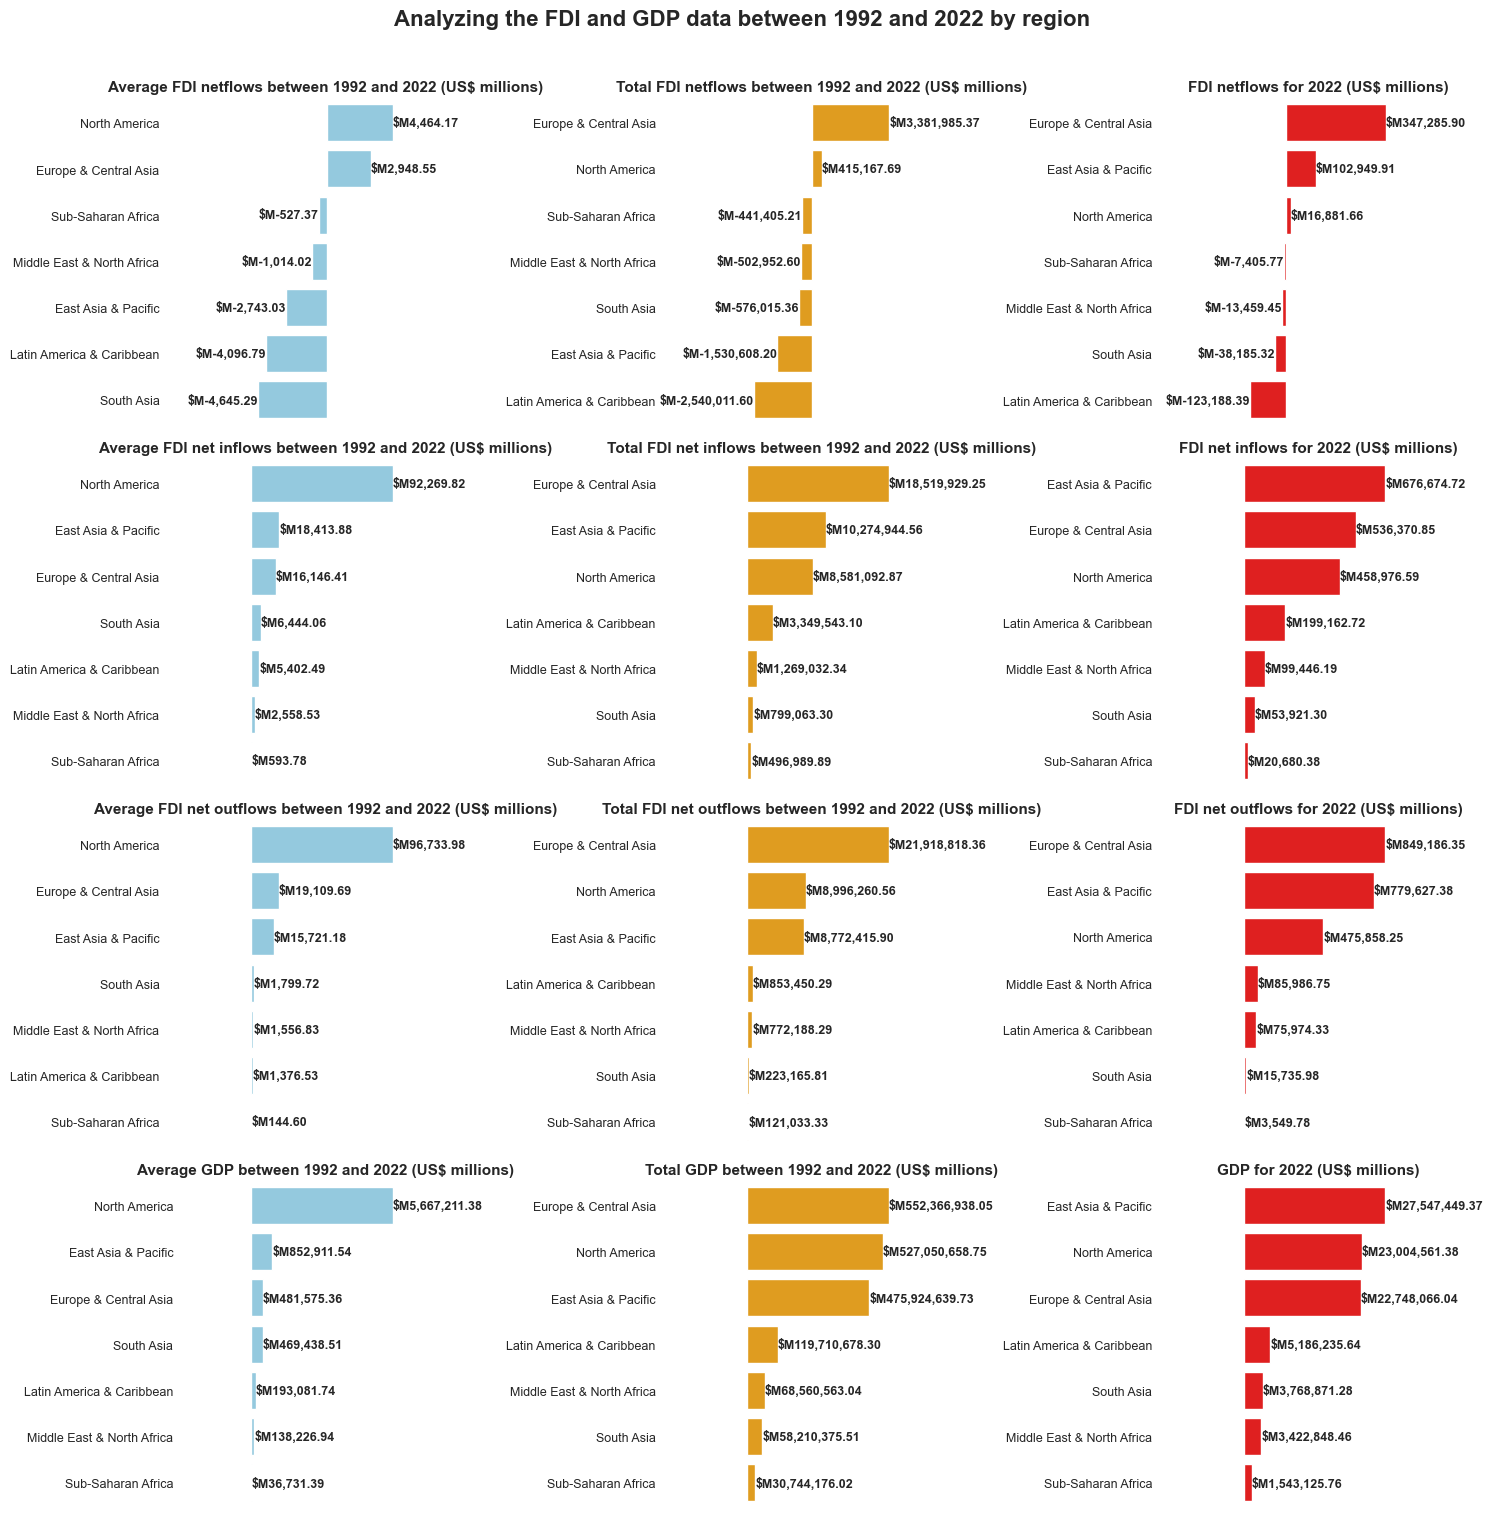

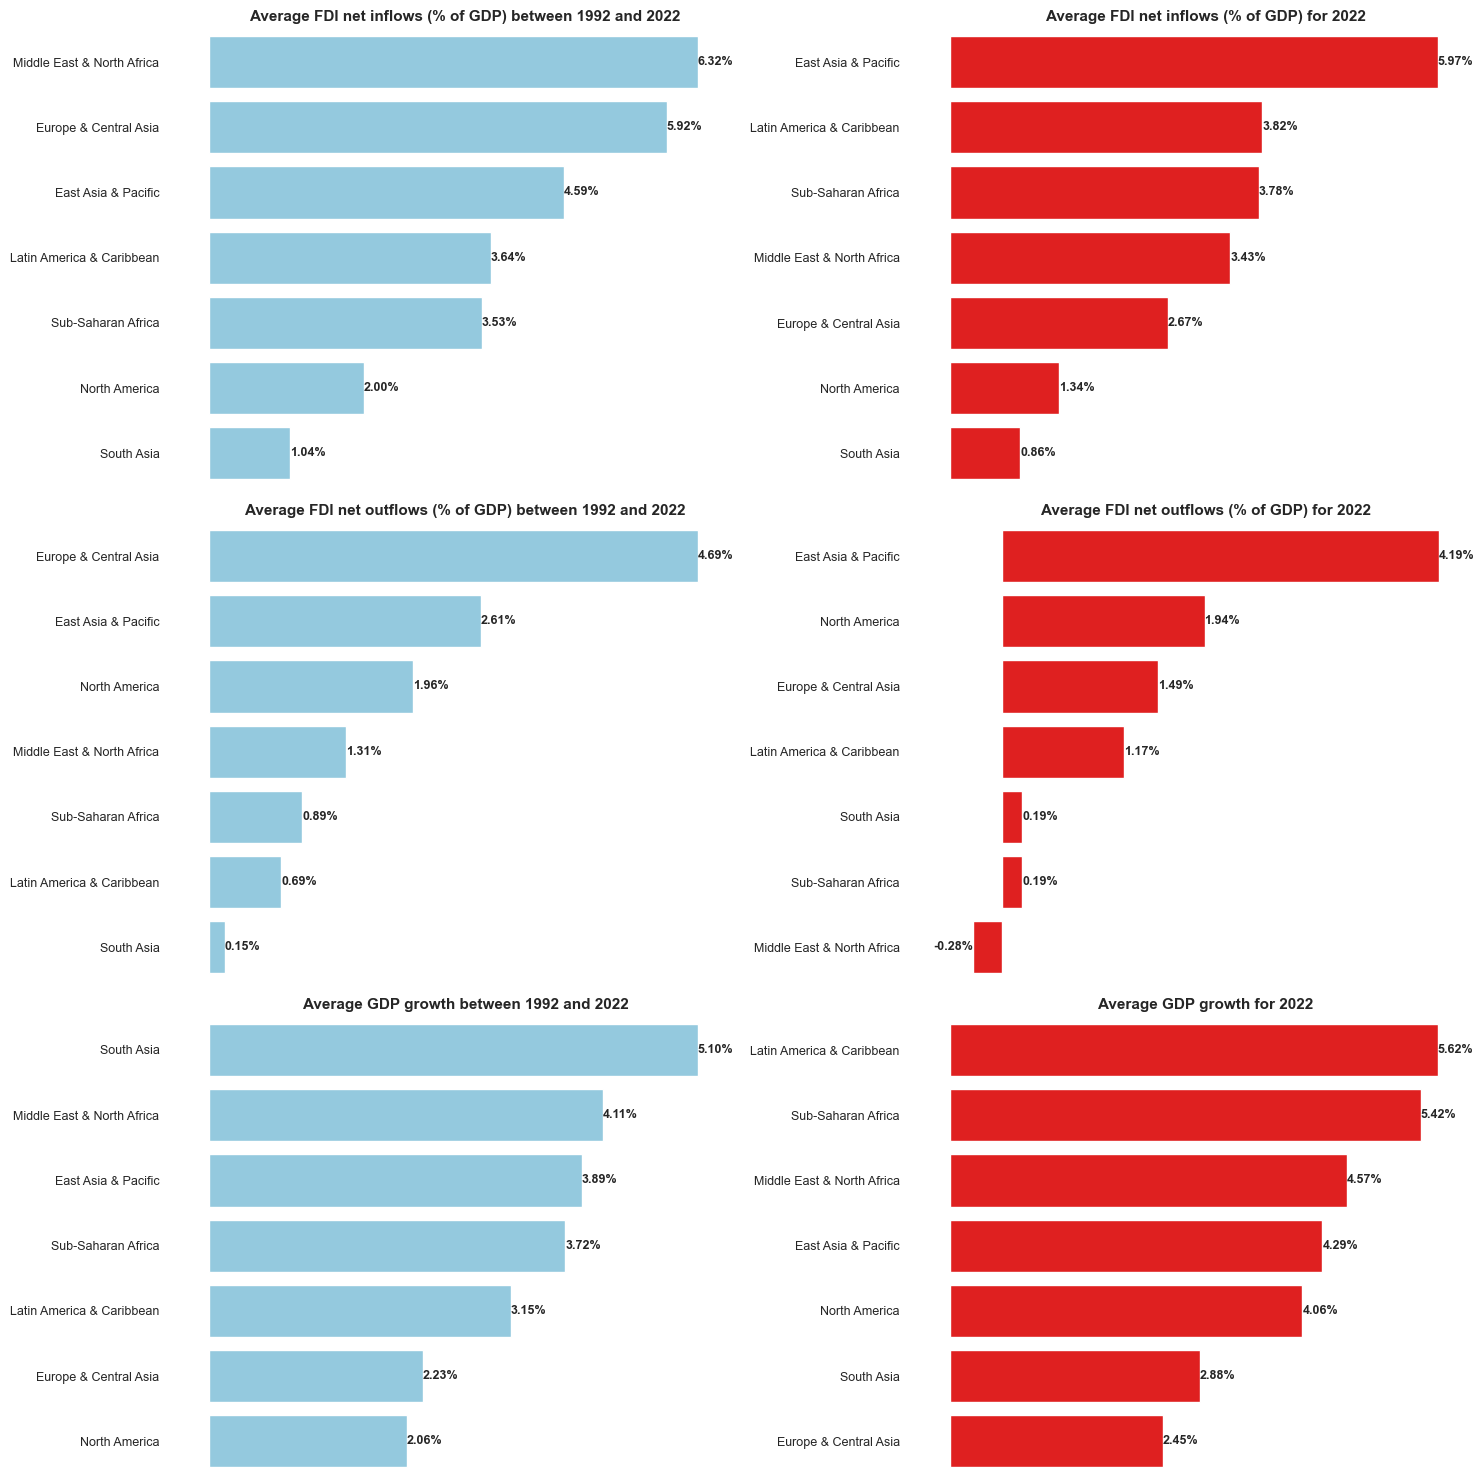

In [61]:
## creating dataframes that aggregate FDI and GDP variables by region

#dataframe that aggregates regions by mean
region_fdi_mean = df_fdi_gdp_final.drop(columns=['Country Code','Country','incomeLevel']).groupby('region').mean().reset_index().round(2)

#dataframe that aggregates regions by sum
region_fdi_sum = df_fdi_gdp_final.drop(columns=['Country Code','Country','incomeLevel']).groupby('region').sum().reset_index().round(2)

#dataframe that aggregates regions by the year 2022
region_fdi_2022_sum = df_fdi_gdp_final[df_fdi_gdp_final.Year==2022].drop(columns=['Country Code','Country','incomeLevel']).groupby('region').sum().reset_index().round(2)
region_fdi_2022_mean = df_fdi_gdp_final[df_fdi_gdp_final.Year==2022].drop(columns=['Country Code','Country','incomeLevel']).groupby('region').mean().reset_index().round(2)

#dataframes that sort values by variables - mean
region_fdi_net_mean = region_fdi_mean.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
region_fdi_in_mean = region_fdi_mean.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
region_fdi_in_pctGDP_mean = region_fdi_mean.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False)
region_fdi_out_mean = region_fdi_mean.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
region_fdi_out_pctGDP_mean = region_fdi_mean.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False)
region_gdp_mean = region_fdi_mean.sort_values(by='GDP (constant 2015 US$)', ascending=False)
region_gdp_growth_mean = region_fdi_mean.sort_values(by='GDP growth (annual %)', ascending=False)
#dataframes that sort values by variables - sum
region_fdi_net_sum = region_fdi_sum.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
region_fdi_in_sum = region_fdi_sum.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
region_fdi_out_sum = region_fdi_sum.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
region_gdp_sum = region_fdi_sum.sort_values(by='GDP (constant 2015 US$)', ascending=False)
#dataframes that sort values by variables - 2022
region_fdi_net_2022 = region_fdi_2022_sum.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
region_fdi_in_2022 = region_fdi_2022_sum.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
region_fdi_in_pctGDP_2022 = region_fdi_2022_mean.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False)
region_fdi_out_2022 = region_fdi_2022_sum.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
region_fdi_out_pctGDP_2022 = region_fdi_2022_mean.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False)
region_gdp_2022 = region_fdi_2022_sum.sort_values(by='GDP (constant 2015 US$)', ascending=False)
region_gdp_growth_2022 = region_fdi_2022_mean.sort_values(by='GDP growth (annual %)', ascending=False)

#creating a function to plot barcharts for fdi and gdp data
def barcharts(df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,y,title):
    #first set of subplots
    fig, ax1 = plt.subplots(nrows=4,ncols=3, figsize=(15,15))
    
    #setting main title
    plt.suptitle('Analyzing the FDI and GDP data between 1992 and 2022 by ' + title, 
                 fontsize=16, 
                 fontweight='bold',
                 y=1.01)
    
    #plotting bar chart average fdi net
    barchart1 = sns.barplot(data=df1,
                            x='Foreign direct investment, net (BoP, current US$)',
                            y=y, 
                            color='skyblue',
                            ax=ax1[0,0])
    #setting title
    ax1[0,0].set_title('Average FDI netflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart1.bar_label(ax1[0,0].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[0,0].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[0,0].set_frame_on(False)

    #plotting bar chart total fdi net
    barchart2 = sns.barplot(data=df2,
                            x='Foreign direct investment, net (BoP, current US$)',
                            y=y, 
                            color='orange',
                            ax=ax1[0,1])
    #setting title
    ax1[0,1].set_title('Total FDI netflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart2.bar_label(ax1[0,1].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[0,1].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[0,1].set_frame_on(False)

    #plotting bar chart 2022 fdi net
    barchart3 = sns.barplot(data=df3,
                            x='Foreign direct investment, net (BoP, current US$)',
                            y=y, 
                            color='red',
                            ax=ax1[0,2])
    #setting title
    ax1[0,2].set_title('FDI netflows for 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart3.bar_label(ax1[0,2].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[0,2].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[0,2].set_frame_on(False)

    #plotting bar chart average fdi net inflows
    barchart4 = sns.barplot(data=df4,
                            x='Foreign direct investment, net inflows (BoP, current US$)',
                            y=y, 
                            color='skyblue',
                            ax=ax1[1,0])
    #setting title
    ax1[1,0].set_title('Average FDI net inflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart4.bar_label(ax1[1,0].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[1,0].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[1,0].set_frame_on(False)

    #plotting bar chart total fdi net inflows
    barchart5 = sns.barplot(data=df5,
                            x='Foreign direct investment, net inflows (BoP, current US$)',
                            y=y, 
                            color='orange',
                            ax=ax1[1,1])
    #setting title
    ax1[1,1].set_title('Total FDI net inflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart5.bar_label(ax1[1,1].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[1,1].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[1,1].set_frame_on(False)

    #plotting bar chart 2022 fdi net inflows
    barchart6 = sns.barplot(data=df6,
                            x='Foreign direct investment, net inflows (BoP, current US$)',
                            y=y, 
                            color='red',
                            ax=ax1[1,2])
    #setting title
    ax1[1,2].set_title('FDI net inflows for 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart6.bar_label(ax1[1,2].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[1,2].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[1,2].set_frame_on(False)

    #plotting bar chart average fdi net outflows
    barchart7 = sns.barplot(data=df7,
                            x='Foreign direct investment, net outflows (BoP, current US$)',
                            y=y, 
                            color='skyblue',
                            ax=ax1[2,0])
    #setting title
    ax1[2,0].set_title('Average FDI net outflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart7.bar_label(ax1[2,0].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[2,0].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[2,0].set_frame_on(False)

    #plotting bar chart total fdi net outflows
    barchart8 = sns.barplot(data=df8,
                            x='Foreign direct investment, net outflows (BoP, current US$)',
                            y=y, 
                            color='orange',
                            ax=ax1[2,1])
    #setting title
    ax1[2,1].set_title('Total FDI net outflows between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart8.bar_label(ax1[2,1].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[2,1].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[2,1].set_frame_on(False)

    #plotting bar chart 2022 fdi net outflows
    barchart9 = sns.barplot(data=df9,
                            x='Foreign direct investment, net outflows (BoP, current US$)',
                            y=y, 
                            color='red',
                            ax=ax1[2,2])
    #setting title
    ax1[2,2].set_title('FDI net outflows for 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart9.bar_label(ax1[2,2].containers[0], 
                        label_type='edge',  
                        fontsize=9, 
                        fontweight='bold',
                        fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[2,2].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[2,2].set_frame_on(False)

    #plotting bar chart average gdp
    barchart10 = sns.barplot(data=df10,
                             x='GDP (constant 2015 US$)',
                             y=y, 
                             color='skyblue',
                             ax=ax1[3,0])
    #setting title
    ax1[3,0].set_title('Average GDP between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart10.bar_label(ax1[3,0].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[3,0].tick_params(axis='y',
                         labelsize=9,
                         pad=50)
    ax1[3,0].set_frame_on(False)

    #plotting bar chart total gdp
    barchart11 = sns.barplot(data=df11,
                             x='GDP (constant 2015 US$)',
                             y=y, 
                             color='orange',
                             ax=ax1[3,1])
    #setting title
    ax1[3,1].set_title('Total GDP between 1992 and 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart11.bar_label(ax1[3,1].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[3,1].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[3,1].set_frame_on(False)

    #plotting bar chart 2022 gdp
    barchart12 = sns.barplot(data=df12,
                             x='GDP (constant 2015 US$)',
                             y=y, 
                             color='red',
                             ax=ax1[3,2])
    #setting title
    ax1[3,2].set_title('GDP for 2022 (US$ millions)',
                       fontweight='bold',
                       fontsize=11)
    #mapping data labels on bars
    barchart12.bar_label(ax1[3,2].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='$M{:,.2f}')
    #adjusting axis and ticks
    ax1[3,2].tick_params(axis='y',
                         labelsize=9,
                         pad=60)
    ax1[3,2].set_frame_on(False)

    #removing xaxis and ylabel
    ax1[0,0].xaxis.set_visible(False)
    ax1[0,1].xaxis.set_visible(False)
    ax1[0,2].xaxis.set_visible(False)
    ax1[1,0].xaxis.set_visible(False)
    ax1[1,1].xaxis.set_visible(False)
    ax1[1,2].xaxis.set_visible(False)
    ax1[2,0].xaxis.set_visible(False)
    ax1[2,1].xaxis.set_visible(False)
    ax1[2,2].xaxis.set_visible(False)
    ax1[3,0].xaxis.set_visible(False)
    ax1[3,1].xaxis.set_visible(False)
    ax1[3,2].xaxis.set_visible(False)

    ax1[0,0].set(ylabel=None)
    ax1[0,1].set(ylabel=None)
    ax1[0,2].set(ylabel=None)
    ax1[1,0].set(ylabel=None)
    ax1[1,1].set(ylabel=None)
    ax1[1,2].set(ylabel=None)
    ax1[2,0].set(ylabel=None)
    ax1[2,1].set(ylabel=None)
    ax1[2,2].set(ylabel=None)
    ax1[3,0].set(ylabel=None)
    ax1[3,1].set(ylabel=None)
    ax1[3,2].set(ylabel=None)

    #adjusting subplot spacing
    plt.tight_layout()

    ###########################################################################################################
    #second set of subplots
    fig, ax2 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

    #plotting bar chart average fdi inflows % of gdp
    barchart13 = sns.barplot(data=df13,
                             x='Foreign direct investment, net inflows (% of GDP)',
                             y=y, 
                             color='skyblue',
                             ax=ax2[0,0])
    #setting title
    ax2[0,0].set_title('Average FDI net inflows (% of GDP) between 1992 and 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart13.bar_label(ax2[0,0].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[0,0].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[0,0].set_frame_on(False)

    #plotting bar chart 2022 fdi inflows % of gdp
    barchart14 = sns.barplot(data=df14,
                             x='Foreign direct investment, net inflows (% of GDP)',
                             y=y, 
                             color='red',
                             ax=ax2[0,1])
    #setting title
    ax2[0,1].set_title('Average FDI net inflows (% of GDP) for 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart14.bar_label(ax2[0,1].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[0,1].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[0,1].set_frame_on(False)
    ####################################################

    #plotting bar chart average fdi outflows % of gdp
    barchart15 = sns.barplot(data=df15,
                             x='Foreign direct investment, net outflows (% of GDP)',
                             y=y, 
                             color='skyblue',
                             ax=ax2[1,0])
    #setting title
    ax2[1,0].set_title('Average FDI net outflows (% of GDP) between 1992 and 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart15.bar_label(ax2[1,0].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[1,0].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[1,0].set_frame_on(False)

    #plotting bar chart 2022 fdi outflows % of gdp
    barchart16 = sns.barplot(data=df16,
                             x='Foreign direct investment, net outflows (% of GDP)',
                             y=y, 
                             color='red',
                             ax=ax2[1,1])
    #setting title
    ax2[1,1].set_title('Average FDI net outflows (% of GDP) for 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart16.bar_label(ax2[1,1].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[1,1].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[1,1].set_frame_on(False)

    #plotting bar chart average gdp
    barchart17 = sns.barplot(data=df17,
                             x='GDP growth (annual %)',
                             y=y, 
                             color='skyblue',
                             ax=ax2[2,0])
    #setting title
    ax2[2,0].set_title('Average GDP growth between 1992 and 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart17.bar_label(ax2[2,0].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[2,0].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[2,0].set_frame_on(False)

    #plotting bar chart 2022 fdi outflows % of gdp
    barchart18 = sns.barplot(data=df18,
                             x='GDP growth (annual %)',
                             y=y, 
                             color='red',
                             ax=ax2[2,1])
    #setting title
    ax2[2,1].set_title('Average GDP growth for 2022',
                        fontweight='bold',
                        fontsize=11)
    #mapping data labels on bars
    barchart18.bar_label(ax2[2,1].containers[0], 
                         label_type='edge',  
                         fontsize=9, 
                         fontweight='bold',
                         fmt='%.2f%%')
    #adjusting axis and ticks
    ax2[2,1].tick_params(axis='y',
                         labelsize=9,
                         pad=30)
    ax2[2,1].set_frame_on(False)

    #removing xaxis and ylabel
    ax2[0,0].xaxis.set_visible(False)
    ax2[0,1].xaxis.set_visible(False)
    ax2[1,0].xaxis.set_visible(False)
    ax2[1,1].xaxis.set_visible(False)
    ax2[2,0].xaxis.set_visible(False)
    ax2[2,1].xaxis.set_visible(False)
    
   
    ax2[0,0].set(ylabel=None)
    ax2[0,1].set(ylabel=None)
    ax2[1,0].set(ylabel=None)
    ax2[1,1].set(ylabel=None)
    ax2[2,0].set(ylabel=None)
    ax2[2,1].set(ylabel=None)  
    
    #adjusting subplots spacing
    plt.tight_layout()

    plt.show()
    
#calling function
barcharts(region_fdi_net_mean,region_fdi_net_sum,region_fdi_net_2022,
          region_fdi_in_mean,region_fdi_in_sum,region_fdi_in_2022, 
          region_fdi_out_mean, region_fdi_out_sum, region_fdi_out_2022, 
          region_gdp_mean, region_gdp_sum, region_gdp_2022,
          region_fdi_in_pctGDP_mean, region_fdi_in_pctGDP_2022,
          region_fdi_out_pctGDP_mean, region_fdi_out_pctGDP_2022,
          region_gdp_growth_mean, region_gdp_growth_2022,
          'region','region')


**Summary of visuals**

1. **FDI Netflows**:
   - Between 1992 and 2022, North America and Europe & Central Asia had positive netflows both in terms of average and total amounts.
   - In 2022, Europe & Central Asia experienced the largest net outflows (USD 329.5 billion), signifying that more investment was sent out from the region. Conversely, Latin America & the Caribbean had the lowest netflows (negative USD 123.4 billion), indicating that the region received more investment than it sent out.

2. **FDI Net Inflows**:
   - Over the 31-year period, Europe & Central Asia and East Asia & Pacific received the largest total foreign investments, exceeding USD 10 trillion each.
   - South Asia and Sub-Saharan Africa received less than USD 1 trillion each in the same period.
   - North America ranked third in total investment but led in average FDI per country (USD 92.7 billion over 31 years).
   - Sub-Saharan Africa had the lowest average FDI (USD 583.8 million).
   - In 2022, the top three regions for FDI inflow were East Asia & Pacific, Europe & Central Asia, and North America.
   - South Asia and Sub-Saharan Africa had relatively low FDI inflows.

3. **FDI Net Outflows**:
   - Between 1992 and 2022, Europe & Central Asia had the highest FDI outflows (USD 21.5 trillion), followed by North America and East Asia & Pacific.
   - North America had the highest average FDI outflow per country (USD 97.7 billion), while Sub-Saharan Africa had the lowest (less than a billion).
   - In 2022, Europe & Central Asia, East Asia & Pacific, and North America collectively committed over USD 500 billion in FDI outflows each.
   - Europe & Central Asia had the highest average FDI outflows as a percentage of GDP (6.65%).

4. **GDP**:
   - Europe & Central Asia, North America, and East Asia & Pacific were the largest economies between 1992 and 2022.
   - In 2022, these three regions remained the top economies, each with over USD 20 trillion.
   - South Asia had the highest average GDP growth (5.10%) over the 31-year period, while North America had the lowest (2.06%).
   - In 2022, Latin America & the Caribbean had the highest average GDP growth (5.62%), and Europe & Central Asia had the lowest (2.45%).


### Trend analysis

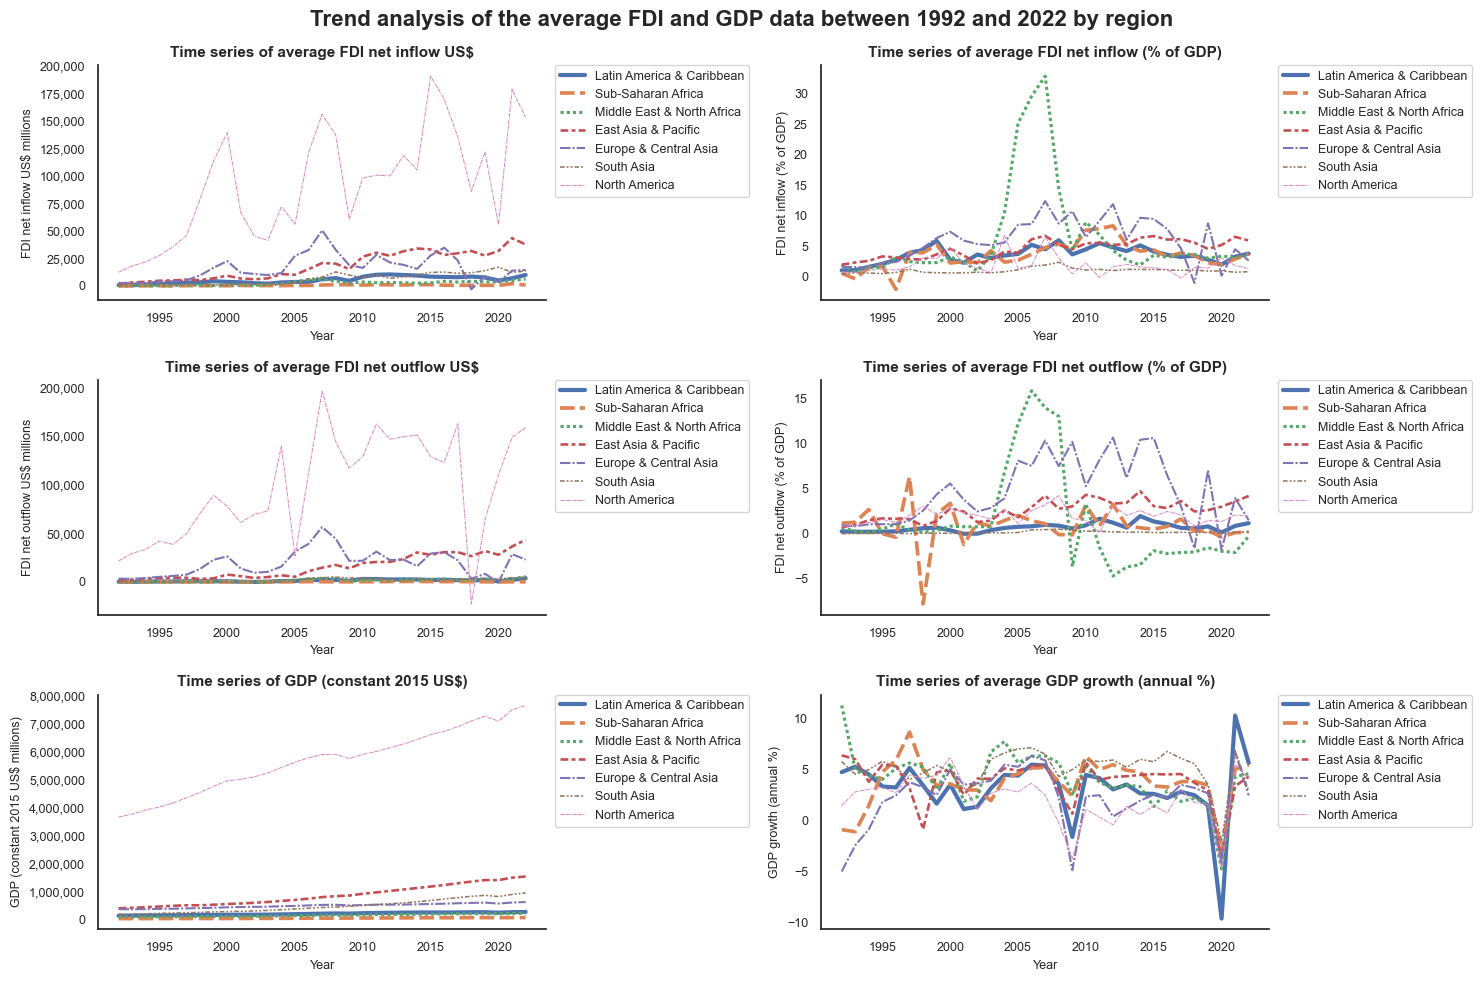

In [64]:
#creating function to plot subplot linecharts
def linecharts(hue, main_title):
    #creating subplots
    fig, ax = plt.subplots(nrows=3,ncols=2, figsize= (15,10))
    
    #plotting line chart average fdi inflow US$ trend
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='Foreign direct investment, net inflows (BoP, current US$)',
                 hue=hue,
                 ci=None, 
                 style=hue,
                 size=hue,
                 ax=ax[0,0])
    #setting title
    ax[0,0].set_title('Time series of average FDI net inflow US$',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[0,0].set_xlabel('Year', 
                       fontsize=9)
    ax[0,0].set_ylabel('FDI net inflow US$ millions', 
                       fontsize=9)
    ax[0,0].tick_params(axis='x', 
                        labelsize=9)
    ax[0,0].tick_params(axis='y', 
                        labelsize=9)
    ax[0,0].spines['top'].set_visible(False)
    ax[0,0].spines['right'].set_visible(False)
    ax[0,0].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left', 
                   borderaxespad=0,
                   fontsize=9)
    ax[0,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    #plotting line chart average FDI % of GDP
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='Foreign direct investment, net inflows (% of GDP)',
                 hue=hue,
                 ci=None, 
                 style=hue,
                 size=hue,
                 ax=ax[0,1])
    #setting title
    ax[0,1].set_title('Time series of average FDI net inflow (% of GDP)',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[0,1].set_xlabel('Year', 
                       fontsize=9)
    ax[0,1].set_ylabel('FDI net inflow (% of GDP)', 
                       fontsize=9)
    ax[0,1].tick_params(axis='x', 
                        labelsize=9)
    ax[0,1].tick_params(axis='y', 
                        labelsize=9)
    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)
    ax[0,1].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left', 
                   borderaxespad=0,
                   fontsize=9)
    
    #plotting line chart average fdi outflow US$ trend
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='Foreign direct investment, net outflows (BoP, current US$)',
                 hue=hue,
                 ci=None, 
                 style=hue,
                 size=hue,
                 ax=ax[1,0])
    #setting title
    ax[1,0].set_title('Time series of average FDI net outflow US$',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[1,0].set_xlabel('Year', 
                       fontsize=9)
    ax[1,0].set_ylabel('FDI net outflow US$ millions', 
                       fontsize=9)
    ax[1,0].tick_params(axis='x', 
                        labelsize=9)
    ax[1,0].tick_params(axis='y', 
                        labelsize=9)
    ax[1,0].spines['top'].set_visible(False)
    ax[1,0].spines['right'].set_visible(False)
    ax[1,0].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left',
                   borderaxespad=0,
                   fontsize=9)
    ax[1,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    #plotting line chart average FDI % of GDP
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='Foreign direct investment, net outflows (% of GDP)',
                 hue=hue,
                 ci=None,  
                 style=hue,
                 size=hue,
                 ax=ax[1,1])
    #setting title
    ax[1,1].set_title('Time series of average FDI net outflow (% of GDP)',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[1,1].set_xlabel('Year', 
                       fontsize=9)
    ax[1,1].set_ylabel('FDI net outflow (% of GDP)', 
                       fontsize=9)
    ax[1,1].tick_params(axis='x', 
                        labelsize=9)
    ax[1,1].tick_params(axis='y', 
                        labelsize=9)
    ax[1,1].spines['top'].set_visible(False)
    ax[1,1].spines['right'].set_visible(False)
    ax[1,1].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left', 
                   borderaxespad=0,
                   fontsize=9)
    
    #plotting line chart average GDP US$ trend
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='GDP (constant 2015 US$)',
                 hue=hue,
                 ci=None,  
                 style=hue,
                 size=hue,
                 ax=ax[2,0])
    #setting title
    ax[2,0].set_title('Time series of GDP (constant 2015 US$)',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[2,0].set_xlabel('Year', 
                       fontsize=9)
    ax[2,0].set_ylabel('GDP (constant 2015 US$ millions)', 
                       fontsize=9)
    ax[2,0].tick_params(axis='x', 
                        labelsize=9)
    ax[2,0].tick_params(axis='y', 
                        labelsize=9)
    ax[2,0].spines['top'].set_visible(False)
    ax[2,0].spines['right'].set_visible(False)
    ax[2,0].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left', 
                   borderaxespad=0,
                   fontsize=9)
    ax[2,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    
    #plotting line chart average GDP growth trend
    sns.lineplot(data=df_fdi_gdp_final, 
                 x='Year', 
                 y='GDP growth (annual %)',
                 hue=hue,
                 ci=None,  
                 style=hue,
                 size=hue,
                 ax=ax[2,1])
    #setting title
    ax[2,1].set_title('Time series of average GDP growth (annual %)',
                      fontweight='bold',
                      fontsize=11,
                      wrap=True)
    #adjusting axis labels and ticks
    ax[2,1].set_xlabel('Year', 
                       fontsize=9)
    ax[2,1].set_ylabel('GDP growth (annual %)', 
                       fontsize=9)
    ax[2,1].tick_params(axis='x', 
                        labelsize=9)
    ax[2,1].tick_params(axis='y', 
                        labelsize=9)
    ax[2,1].spines['top'].set_visible(False)
    ax[2,1].spines['right'].set_visible(False)
    ax[2,1].legend(bbox_to_anchor=(1.02, 1),
                   loc='upper left', 
                   borderaxespad=0,
                   fontsize=9)

    #setting main title
    plt.suptitle('Trend analysis of the average FDI and GDP data between 1992 and 2022 by ' + main_title, 
                 fontsize=16, 
                 fontweight='bold') 
    
    #adjusting subplot spacing
    plt.tight_layout()

#calling linechart function
linecharts('region','region')

**Summary of visuals**

- **North America FDI Inflows:**
  - Fluctuating trend over time.
  - Periods of sharp increases and declines.
- **FDI as a percentage of Middle East & North Africa:**
    - Sharp increase in the early 2000s.
    - Decline in the mid and late 2000s.

- **Europe & Central Asia FDI Inflows:**
  - Consistent fluctuations since the early 2000s until 2022.

- **FDI Outflows (Both Regions):**
  - Similar pattern observed.

- **GDP Growth (All Regions):**
  - Generally upward trend.
  - North America has a steeper slope.

In [66]:
region_fdi_sum

region     Year  \
0         East Asia & Pacific  1119906   
1       Europe & Central Asia  2302029   
2   Latin America & Caribbean  1244340   
3  Middle East & North Africa   995472   
4               North America   186651   
5                  South Asia   248868   
6          Sub-Saharan Africa  1679859   

   Foreign direct investment, net (BoP, current US$)  \
0                                     -1,530,608.200   
1                                      3,381,985.370   
2                                     -2,540,011.600   
3                                       -502,952.600   
4                                        415,167.690   
5                                       -576,015.360   
6                                       -441,405.210   

   Foreign direct investment, net inflows (% of GDP)  \
0                                          2,559.670   
1                                          6,795.910   
2                                          2,253.740   
3                                          3,134.760   
4                                            185.810   
5                                            129.560   
6                                          2,955.610   

   Foreign direct investment, net inflows (BoP, current US$)  \
0                                     10,274,944.560           
1                                     18,519,929.250           
2                                      3,349,543.100           
3                                      1,269,032.340           
4                                      8,581,092.870           
5                                        799,063.300           
6                                        496,989.890           

   Foreign direct investment, net outflows (% of GDP)  \
0                                          1,456.070    
1                                          5,381.910    
2                                            424.800    
3                                            651.160    
4                                            182.260    
5                                             18.400    
6                                            745.840    

   Foreign direct investment, net outflows (BoP, current US$)  \
0                                      8,772,415.900            
1                                     21,918,818.360            
2                                        853,450.290            
3                                        772,188.290            
4                                      8,996,260.560            
5                                        223,165.810            
6                                        121,033.330            

   GDP (constant 2015 US$)  GDP growth (annual %)  
0          475,924,639.730              2,173.030  
1          552,366,938.050              2,558.530  
2          119,710,678.300              1,953.360  
3           68,560,563.040              2,036.150  
4          527,050,658.750                191.650  
5           58,210,375.510                632.630  
6           30,744,176.020              3,111.720

In [67]:
df_fdi_gdp_final

Country Code   Country                     region          incomeLevel  \
0             ABW     Aruba  Latin America & Caribbean          High income   
1             ABW     Aruba  Latin America & Caribbean          High income   
2             ABW     Aruba  Latin America & Caribbean          High income   
3             ABW     Aruba  Latin America & Caribbean          High income   
4             ABW     Aruba  Latin America & Caribbean          High income   
...           ...       ...                        ...                  ...   
6722          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6723          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6724          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6725          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6726          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   

      Year  Foreign direct investment, net (BoP, current US$)  \
0     1992                                             36.983   
1     1993                                             17.933   
2     1994                                             73.184   
3     1995                                              5.531   
4     1996                                            -84.134   
...    ...                                                ...   
6722  2018                                           -717.079   
6723  2019                                           -247.096   
6724  2020                                           -153.860   
6725  2021                                           -218.000   
6726  2022                                           -336.800   

      Foreign direct investment, net inflows (% of GDP)  \
0                                                -3.858   
1                                                -1.655   
2                                                -5.874   
3                                                -0.419   
4                                                 6.162   
...                                                 ...   
6722                                              2.102   
6723                                              1.143   
6724                                              0.699   
6725                                              0.881   
6726                                              1.444   

      Foreign direct investment, net inflows (BoP, current US$)  \
0                                               -36.983           
1                                               -17.933           
2                                               -73.184           
3                                                -5.531           
4                                                85.028           
...                                                 ...           
6722                                            717.865           
6723                                            249.500           
6724                                            150.360           
6725                                            250.000           
6726                                            395.100           

      Foreign direct investment, net outflows (% of GDP)  \
0                                                 1.037    
1                                                 0.634    
2                                                 0.121    
3                                                 0.127    
4                                                 0.065    
...                                                 ...    
6722                                              0.002    
6723                                              0.011    
6724                                             -0.016    
6725                                              0.113    
6726                                              0.213    

      Foreign direct investment, net out

### Share of global FDI

In [69]:
#creating a new column that shows percentage share of FDI inflow
region_fdi_sum = df_fdi_gdp_final.drop(columns=['Country Code','Country','incomeLevel']).groupby('region').sum().reset_index().round(2)

region_fdi_in_sum['Percentage of average FDI inflow'] = \
region_fdi_in_sum['Foreign direct investment, net inflows (BoP, current US$)'].apply(lambda x: (x / region_fdi_in_sum['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

region_fdi_in_2022['Percentage of average FDI inflow'] = \
region_fdi_in_2022['Foreign direct investment, net inflows (BoP, current US$)'].apply(lambda x: (x / region_fdi_in_2022['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

#creating a new column that shpws percentage share of FDI outflow
region_fdi_out_sum['Percentage of average FDI outflow'] = \
region_fdi_out_sum['Foreign direct investment, net outflows (BoP, current US$)'].apply(lambda x: (x / region_fdi_out_sum['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

region_fdi_out_2022['Percentage of average FDI outflow'] = \
region_fdi_out_2022['Foreign direct investment, net outflows (BoP, current US$)'].apply(lambda x: (x / region_fdi_out_2022['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)


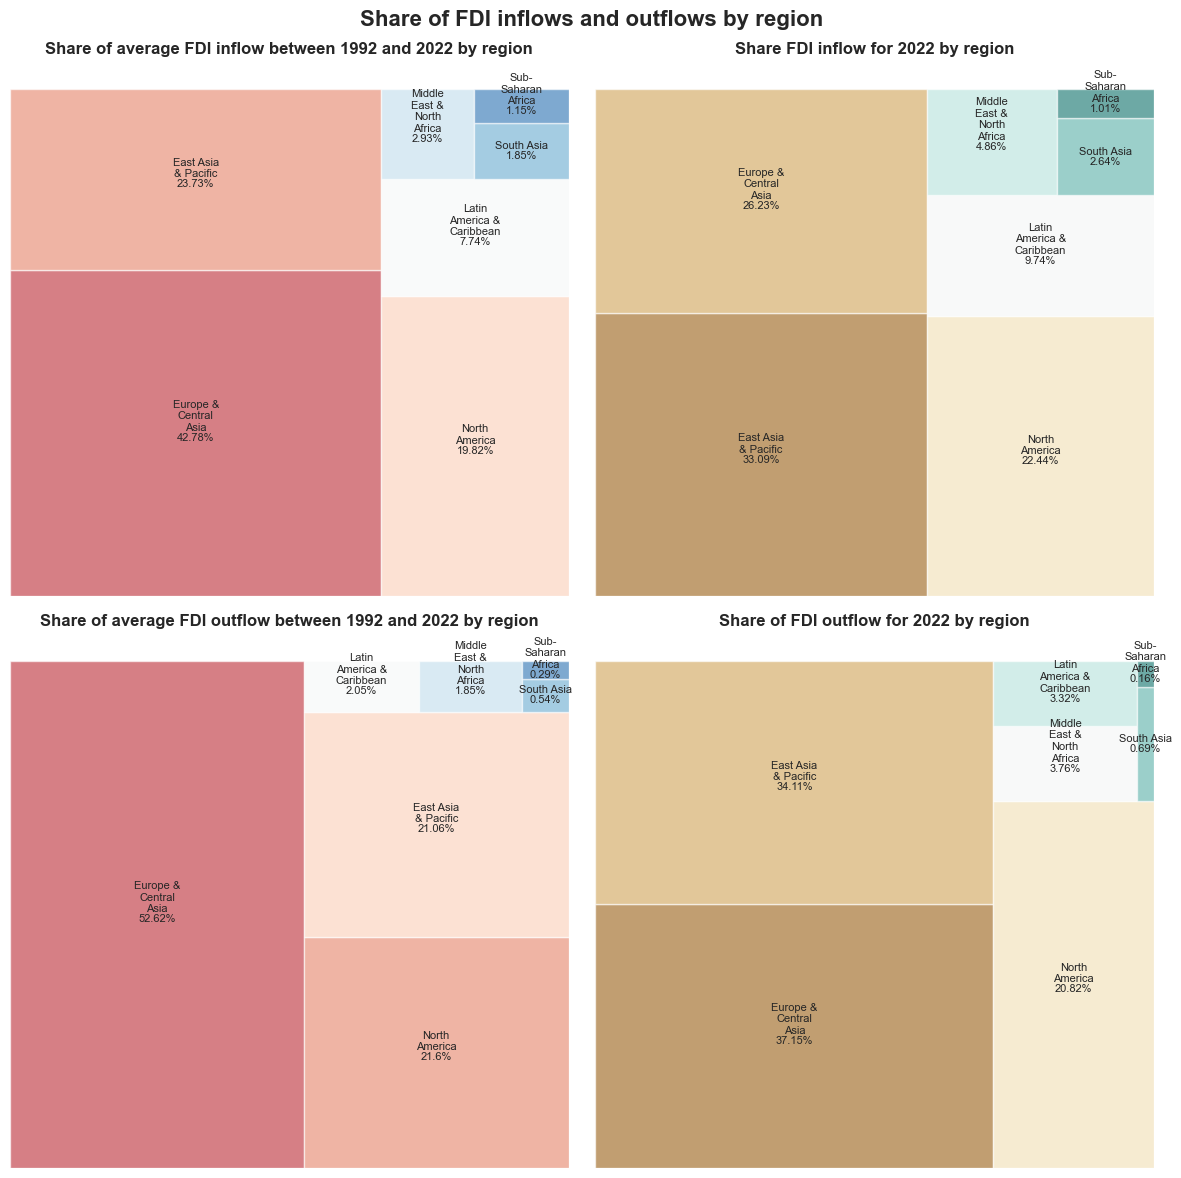

In [70]:
#creating function to plot a tree map that will calculate the share of fdi data 

#creating list of percentages for fdi data
region_fdi_in_pct_share_sum=list(region_fdi_in_sum['Percentage of average FDI inflow'].astype(str)+'%')
region_fdi_in_pct_share_2022=list(region_fdi_in_2022['Percentage of average FDI inflow'].astype(str)+'%')
region_fdi_out_pct_share_sum=list(region_fdi_out_sum['Percentage of average FDI outflow'].astype(str)+'%')
region_fdi_out_pct_share_2022=list(region_fdi_out_2022['Percentage of average FDI outflow'].astype(str)+'%')

#creating list of labels and wrapping the labels
labels1 = list(region_fdi_in_sum.region)
labels2 = list(region_fdi_in_2022.region)
labels3 = list(region_fdi_out_sum.region)
labels4 = list(region_fdi_out_2022.region)
wrapped_labels_in_sum = [textwrap.fill(label, width=10) for label in labels1]
wrapped_labels_in_2022 = [textwrap.fill(label, width=10) for label in labels2]
wrapped_labels_out_sum = [textwrap.fill(label, width=10) for label in labels3]
wrapped_labels_out_2022 = [textwrap.fill(label, width=10) for label in labels4]

#creating tree map function
def treemaps(df1,df2,df3,df4,label1,label2,label3,label4,value1,value2,value3,value4,title):
    fig,ax = plt.subplots(2,2, figsize=(12,12))
    
    #plotting treemap fdi inflow average share
    squarify.plot(df1,
                  label=label1, 
                  alpha=.6, 
                  text_kwargs={'fontsize':8,
                               'wrap':True}, 
                  value=value1,
                  color=sns.color_palette('RdBu', 
                                          len(df1)),
                  ax=ax[0,0])
    
    #plotting treemap fdi inflow 2022 share
    squarify.plot(df2,
                  label=label2, 
                  alpha=.6, 
                  text_kwargs={'fontsize':8,
                               'wrap':True}, 
                  value=value2,
                  color=sns.color_palette('BrBG', 
                                          len(df2)),
                  ax=ax[0,1])

    #plotting treemap fdi outflow average share
    squarify.plot(df3,
                  label=label3, 
                  alpha=.6, 
                  text_kwargs={'fontsize':8,
                               'wrap':True}, 
                  value=value3,
                  color=sns.color_palette('RdBu', 
                                          len(df3)),
                  ax=ax[1,0])
    
    #plotting treemap fdi outflow 2022 share
    squarify.plot(df4,
                  label=label4, 
                  alpha=.6, 
                  text_kwargs={'fontsize':8,
                               'wrap':True}, 
                  value=value4,
                  color=sns.color_palette('BrBG', 
                                          len(df4)),
                  ax=ax[1,1])
    
    #setting titles
    ax[0,0].set_title('Share of average FDI inflow between 1992 and 2022 by '+ title, 
                      fontsize=12, 
                      fontweight='bold', 
                      pad=25)
    ax[0,1].set_title('Share FDI inflow for 2022 by '+ title,
                      fontsize=12, 
                      fontweight='bold',
                      pad=25)

    ax[1,0].set_title('Share of average FDI outflow between 1992 and 2022 by '+ title, 
                      fontsize=12, 
                      fontweight='bold', 
                      pad=25),
    ax[1,1].set_title('Share of FDI outflow for 2022 by '+ title,
                      fontsize=12, 
                      fontweight='bold',
                      pad=25)
    
    #removing axis values
    ax[0,0].axis("off")
    ax[0,1].axis("off")
    ax[1,0].axis("off")
    ax[1,1].axis("off")

    #setting main title
    plt.suptitle('Share of FDI inflows and outflows by '+ title, 
                 fontsize=16, 
                 fontweight='bold')

    #adjusting subplot spacing
    fig.tight_layout()


#calling function
treemaps(region_fdi_in_sum['Percentage of average FDI inflow'],
         region_fdi_in_2022['Percentage of average FDI inflow'],
         region_fdi_out_sum['Percentage of average FDI outflow'],
         region_fdi_out_2022['Percentage of average FDI outflow'],
         wrapped_labels_in_sum, 
         wrapped_labels_in_2022,
         wrapped_labels_out_sum, 
         wrapped_labels_out_2022,
         region_fdi_in_pct_share_sum,
         region_fdi_in_pct_share_2022,
         region_fdi_out_pct_share_sum, 
         region_fdi_out_pct_share_2022,
         'region')

**Summary of visuals**

1.	**FDI Inflows:**
    -	Between 1992 and 2022, Europe & Central Asia consistently held a significant share of global FDI inflows, accounting for over 42.6% on average.
    -	Following closely were East Asia & Pacific (23.79%) and North America (19.88%).
    -	South Asia and Sub-Saharan Africa have the lowest share, contributing less than 2% to global FDI inflow for the period.
    -	In 2022, the top four regions with double-digit global FDI shares were: 
        -	East Asia & Pacific (33.83%)
        -	Europe & Central Asia (25.02%) and North America (22.15%)
        -	Latin America & Caribbean (10.19%)
        -	Sub-Saharan Africa’s share remained modest, just over 1%.
2.	**FDI Outflows:**
    -	Between 1992 and 2022, Europe & Central Asia led in FDI outflows, accounting for a substantial 52.12% share.
    -	East Asia & Pacific and North America each had over 20% of the global FDI outflow share.
    -	South Asia and Sub-Saharan Africa’s contribution was below 1%.
    -	In 2022, the top three regions with the highest FDI outflow shares were: 
        -	Europe & Central Asia (36.99%)
        -	East Asia & Pacific (31.87%)
        -	North America (23.03%)
    -	Sub-Saharan Africa had the smallest share, less than 1%


## Analysis by income level

### Aggregations

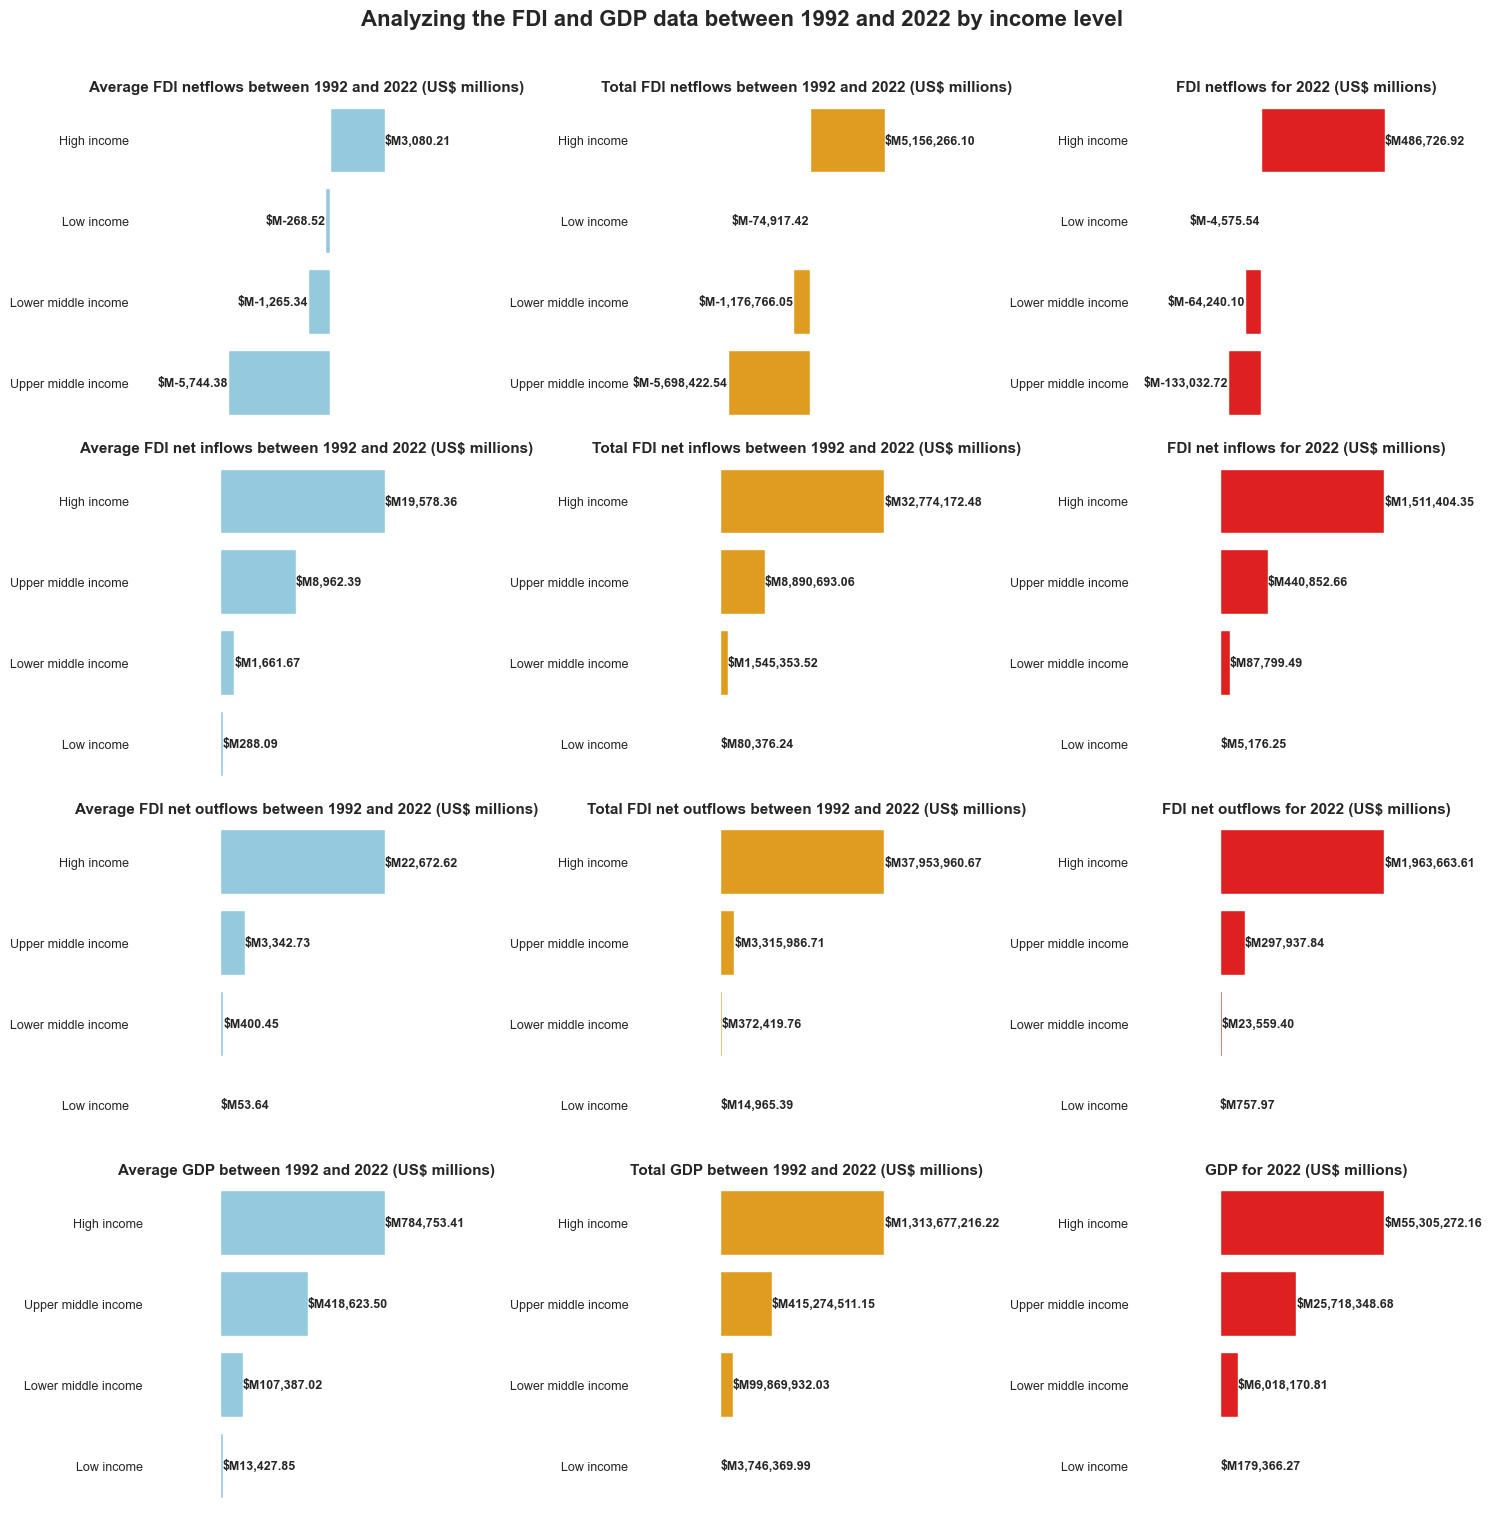

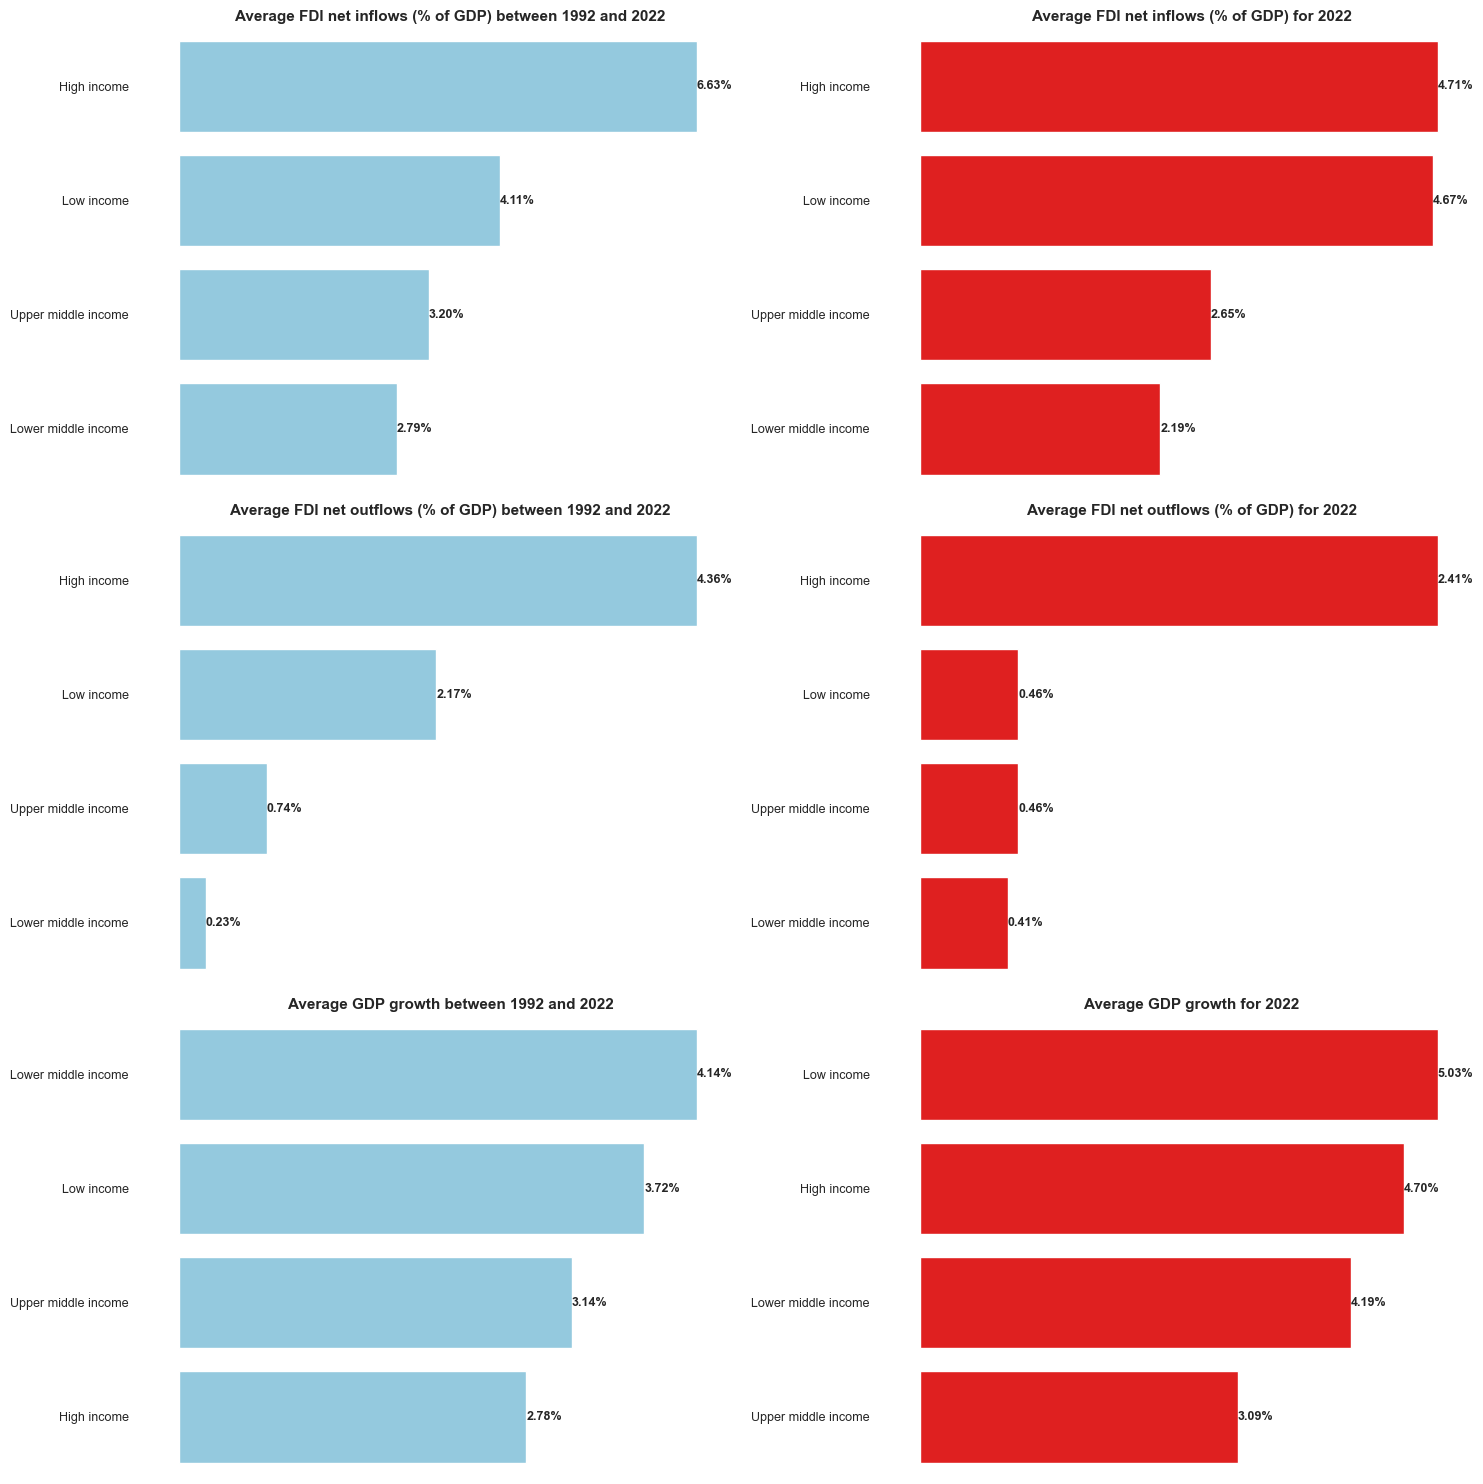

In [74]:
#creating dataframes that aggregate FDI and GDP variables by income level

#dataframe that aggregates regions by mean
incomelevel_fdi_mean = df_fdi_gdp_final.drop(columns=['Country Code','Country','region']).groupby('incomeLevel').mean().reset_index().round(2)

#dataframe that aggregates regions by sum
incomelevel_fdi_sum = df_fdi_gdp_final.drop(columns=['Country Code','Country','region']).groupby('incomeLevel').sum().reset_index().round(2)

#dataframe that aggregates regions by the year 2022
incomelevel_fdi_2022_mean = df_fdi_gdp_final[df_fdi_gdp_final.Year==2022].drop(columns=['Country Code','Country','region']).groupby('incomeLevel').mean().reset_index().round(2)
incomelevel_fdi_2022_sum = df_fdi_gdp_final[df_fdi_gdp_final.Year==2022].drop(columns=['Country Code','Country','region']).groupby('incomeLevel').sum().reset_index().round(2)

#dataframes that sort values by variables - mean
incomelevel_fdi_net_mean = incomelevel_fdi_mean.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
incomelevel_fdi_in_mean = incomelevel_fdi_mean.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
incomelevel_fdi_in_pctGDP_mean = incomelevel_fdi_mean.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False)
incomelevel_fdi_out_mean = incomelevel_fdi_mean.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
incomelevel_fdi_out_pctGDP_mean = incomelevel_fdi_mean.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False)
incomelevel_gdp_mean = incomelevel_fdi_mean.sort_values(by='GDP (constant 2015 US$)', ascending=False)
incomelevel_gdp_growth_mean = incomelevel_fdi_mean.sort_values(by='GDP growth (annual %)', ascending=False)
#dataframes that sort values by variables - sum
incomelevel_fdi_net_sum = incomelevel_fdi_sum.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
incomelevel_fdi_in_sum = incomelevel_fdi_sum.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
incomelevel_fdi_out_sum = incomelevel_fdi_sum.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
incomelevel_gdp_sum = incomelevel_fdi_sum.sort_values(by='GDP (constant 2015 US$)', ascending=False)
#dataframes that sort values by variables - 2022
incomelevel_fdi_net_2022 = incomelevel_fdi_2022_sum.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False)
incomelevel_fdi_in_2022 = incomelevel_fdi_2022_sum.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)', ascending=False)
incomelevel_fdi_in_pctGDP_2022 = incomelevel_fdi_2022_mean.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False)
incomelevel_fdi_out_2022 = incomelevel_fdi_2022_sum.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False)
incomelevel_fdi_out_pctGDP_2022 = incomelevel_fdi_2022_mean.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False)
incomelevel_gdp_2022 = incomelevel_fdi_2022_sum.sort_values(by='GDP (constant 2015 US$)', ascending=False)
incomelevel_gdp_growth_2022 = incomelevel_fdi_2022_mean.sort_values(by='GDP growth (annual %)', ascending=False)


#calling barchart function
barcharts(incomelevel_fdi_net_mean,incomelevel_fdi_net_sum,incomelevel_fdi_net_2022,
          incomelevel_fdi_in_mean,incomelevel_fdi_in_sum,incomelevel_fdi_in_2022, 
          incomelevel_fdi_out_mean, incomelevel_fdi_out_sum, incomelevel_fdi_out_2022, 
          incomelevel_gdp_mean, incomelevel_gdp_sum, incomelevel_gdp_2022,
          incomelevel_fdi_in_pctGDP_mean, incomelevel_fdi_in_pctGDP_2022,
          incomelevel_fdi_out_pctGDP_mean, incomelevel_fdi_out_pctGDP_2022,
          incomelevel_gdp_growth_mean, incomelevel_gdp_growth_2022,
          'incomeLevel','income level')


**Summary of visuals**

1.	**FDI Netflows:**
    -	Only high-income economies consistently show positive netflows (more inflows than outflows) both in average and total amounts between 1992 and 2022.
    -	In 2022, high-income economies had the largest netflows, totaling USD 527.7 billion, while upper middle-income economies had the lowest netflows at -USD 133.8 billion.
2.	**FDI Inflows:**
    -	Between 1992 and 2022, high-income economies received the most foreign investment, amounting to $32.6 trillion.
    -	Low-income economies received the least, with a total of USD 80.8 billion over the same period.
    -	In 2022, high-income economies attracted over USD 1.4 trillion in FDI, while low-income economies received only USD 5.6 billion.
    -	High-income economies also had the highest average FDI inflow as a percentage of GDP (6.62%) over the entire period, but in 2022, low-income economies had the highest average (4.71%).
3.	**FDI Outflows:**
    -	High-income economies sent out the most investment over the 31-year period, aggregating to a staggering USD 37.6 trillion.
    -	In contrast, low-income economies had the lowest outflows, totaling just over USD 14.9 billion.
    -	When considering FDI outflows as a percentage of GDP, high-income economies maintained the highest average between 1992 and 2022 (4.33%).
    -	In 2022, low-income economies had the lowest average share (less than 1%).
4.	**GDP:**
    -	The aggregate GDP for high-income economies between 1992 and 2022 reached USD 1.3 quadrillion, the highest among all income groups.
    -	Low-income economies had the lowest aggregate GDP, standing at USD 3.7 trillion.
    -	In 2022, high-income economies’ GDP aggregated to USD 55.3 trillion, while low-income economies had the lowest at USD 179.4 billion.
    -	Over the 31-year period, low middle-income economies experienced the highest average GDP growth (4.12%), while high-income economies had the lowest average growth (2.78%).
    -	In 2022, low-income economies led in average GDP growth (5.03%), while upper middle-income economies had the lowest growth rate (3.09%).

### Trend analysis

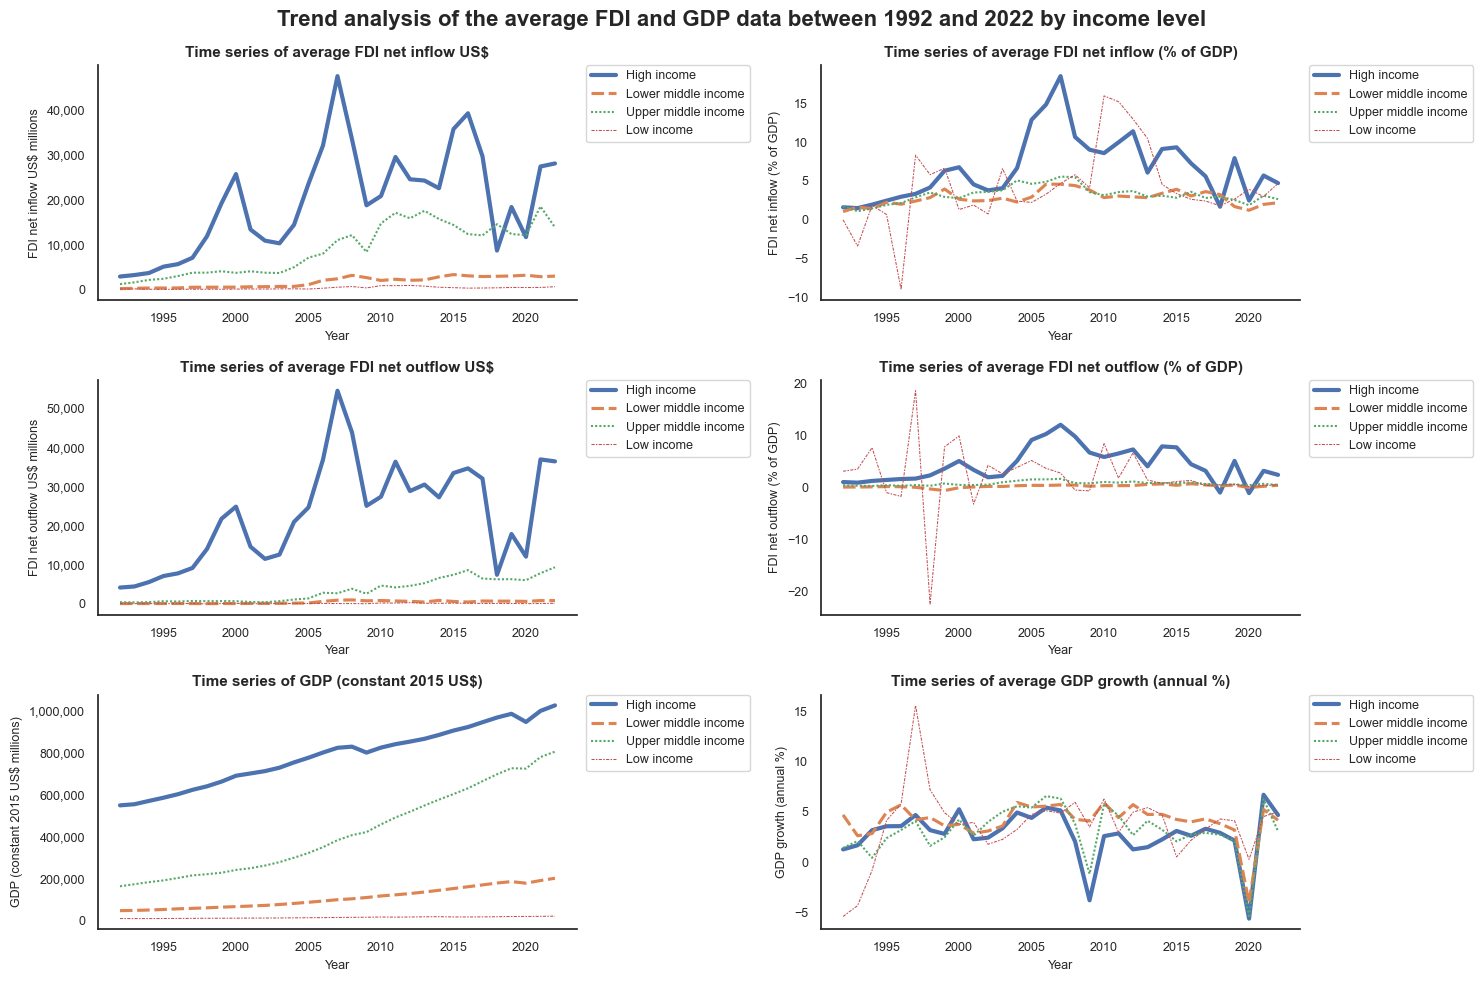

In [77]:
#calling back line chart function
linecharts('incomeLevel','income level')

**Summary of visuals**

1.	**FDI Inflows:**
    -	**High-Income Economies:**
        -	Fluctuations with sharp growth and declines over 31 years.
    -	**Upper Middle-Income Economies:** 
        -	Gradual upward trend since the early 2000s until 2022.
    -	**Low and Low Middle-Income Economies:** 
        -	Relatively flat trend.
          
2.	**FDI Inflow as % of GDP:**
    -	**High-Income and Low-Income Countries:** 
        -	Most fluctuations.
    -	**Lower Middle and Upper Middle-Income Economies:** 
        -	Stable patterns.
          
3. **FDI Outflows:**
    -	**High-Income Economies:** 
        -	Highest fluctuations compared to other economies.
    -	**FDI Outflow as % of GDP:** 
        -	**High-Income Economies:** 
            -	General decline from mid-2000s to 2022.
        -	**Low-Income Economies:** 
            -	Fluctuations from 1992 to mid-2010.
        -	**Lower Middle and Upper Middle-Income Economies:** 
            -	Stability throughout.
              
4.	**GDP Growth:**
    -	**High-Income and Middle-Income Economies:** 
        -	Rapid increase since the mid-2000s.
    -	**Low and Lower Middle-Income Economies:** 
        -	Slower growth.
    -	Overall, GDP growth shows consistent fluctuations across all economies.


### Share of global FDI

In [80]:
#creating a new column that shows percentage share of FDI inflow
incomelevel_fdi_in_sum['Percentage of average FDI inflow'] = \
incomelevel_fdi_in_sum['Foreign direct investment, net inflows (BoP, current US$)']\
.apply(lambda x: (x / incomelevel_fdi_in_sum['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

incomelevel_fdi_in_2022['Percentage of average FDI inflow'] = \
incomelevel_fdi_in_2022['Foreign direct investment, net inflows (BoP, current US$)']\
.apply(lambda x: (x / incomelevel_fdi_in_2022['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)


#creating a new column that shows percentage share of FDI outflow
incomelevel_fdi_out_sum['Percentage of average FDI outflow'] = \
incomelevel_fdi_out_sum['Foreign direct investment, net outflows (BoP, current US$)']\
.apply(lambda x: (x / incomelevel_fdi_out_sum['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

incomelevel_fdi_out_2022['Percentage of average FDI outflow'] = \
incomelevel_fdi_out_2022['Foreign direct investment, net outflows (BoP, current US$)']\
.apply(lambda x: (x / incomelevel_fdi_out_2022['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

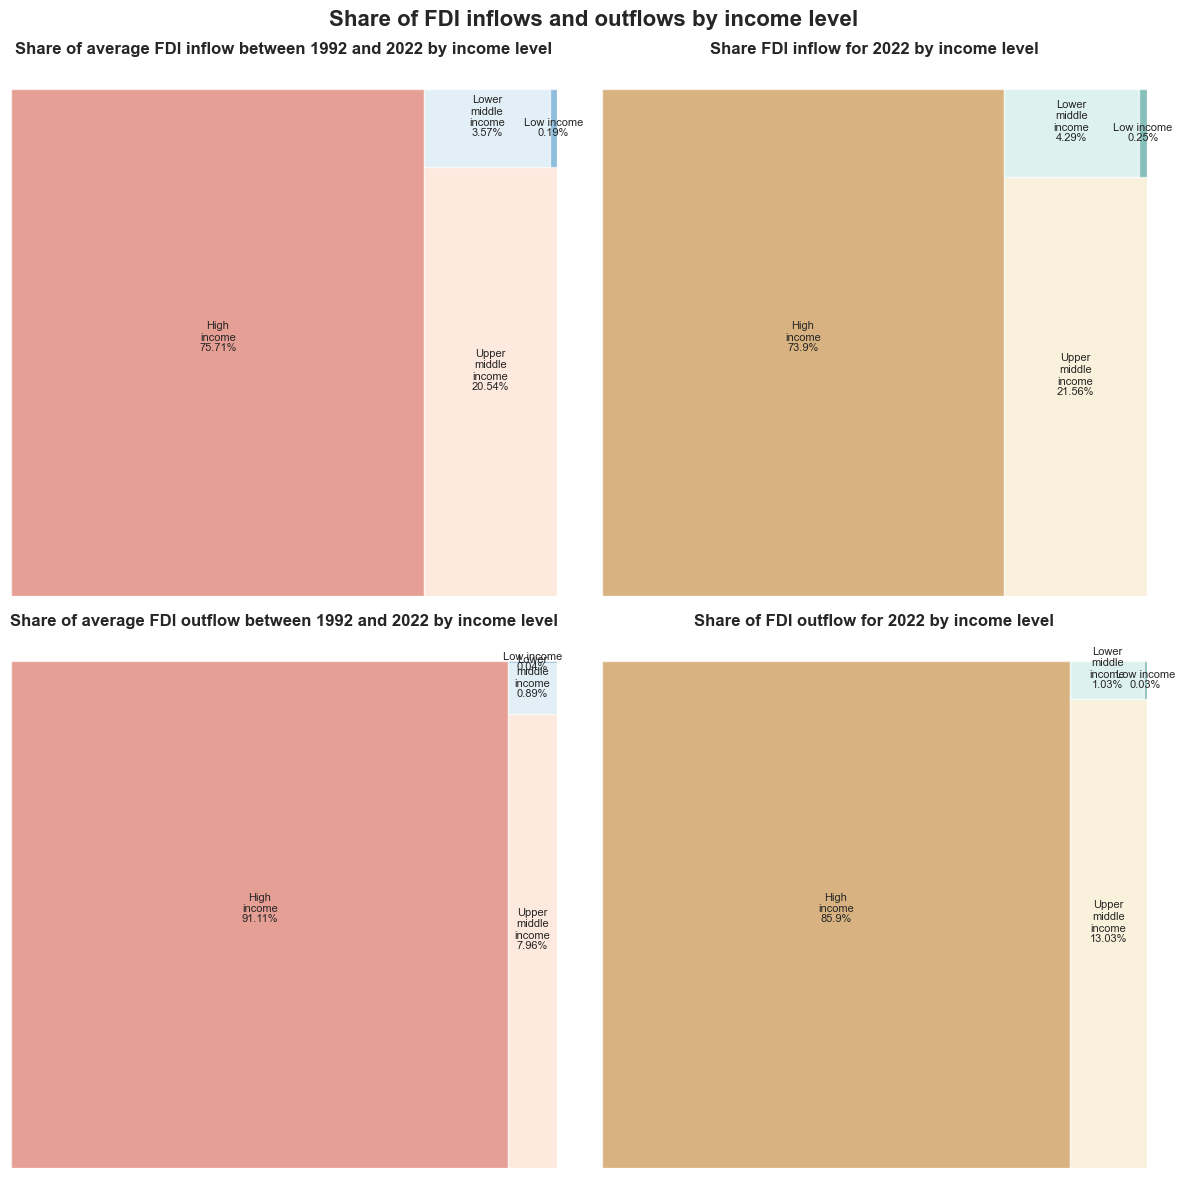

In [81]:
incomelevel_fdi_in_pct_share_sum=list(incomelevel_fdi_in_sum['Percentage of average FDI inflow'].astype(str)+'%')
incomelevel_fdi_in_pct_share_2022=list(incomelevel_fdi_in_2022['Percentage of average FDI inflow'].astype(str)+'%')
incomelevel_fdi_out_pct_share_sum=list(incomelevel_fdi_out_sum['Percentage of average FDI outflow'].astype(str)+'%')
incomelevel_fdi_out_pct_share_2022=list(incomelevel_fdi_out_2022['Percentage of average FDI outflow'].astype(str)+'%')

labels1 = list(incomelevel_fdi_in_sum.incomeLevel)
labels2 = list(incomelevel_fdi_in_2022.incomeLevel)
labels3 = list(incomelevel_fdi_out_sum.incomeLevel)
labels4 = list(incomelevel_fdi_out_2022.incomeLevel)
wrapped_labels_in_sum = [textwrap.fill(label, width=10) for label in labels1]
wrapped_labels_in_2022 = [textwrap.fill(label, width=10) for label in labels2]
wrapped_labels_out_sum = [textwrap.fill(label, width=10) for label in labels3]
wrapped_labels_out_2022 = [textwrap.fill(label, width=10) for label in labels4]


treemaps(incomelevel_fdi_in_sum['Percentage of average FDI inflow'],
         incomelevel_fdi_in_2022['Percentage of average FDI inflow'],
         incomelevel_fdi_out_sum['Percentage of average FDI outflow'],
         incomelevel_fdi_out_2022['Percentage of average FDI outflow'],
         wrapped_labels_in_sum, 
         wrapped_labels_in_2022,
         wrapped_labels_out_sum,
         wrapped_labels_out_2022,
         incomelevel_fdi_in_pct_share_sum,
         incomelevel_fdi_in_pct_share_2022,
         incomelevel_fdi_out_pct_share_sum, 
         incomelevel_fdi_out_pct_share_2022,
         'income level')

**Summary of visuals**

1. **FDI Inflows**:
   - Between 1992 and 2022, high-income and upper middle-income economies dominated FDI inflows globally.
   - On average, high-income economies accounted for a substantial share of 75.64%, while upper middle-income economies followed with 20.57%.
   - In contrast, lower middle-income and low-income economies had significantly smaller shares: 5.33% and 0.95%, respectively.
   - Looking specifically at 2022, high-income economies increased their share to 73.55%, while upper middle-income economies held 21.7%. Lower middle-income economies contributed 4.47%, and low-income economies remained below 1%.

2. **FDI Outflows**:
   - Over the same period (1992–2022), high-income economies were the major contributors to global FDI outflows.
   - Their share was substantial at 91.19%, followed by upper middle-income economies with 7.88%.
   - Lower middle-income and low-income economies had smaller shares of below 1% each
   - Interestingly, the distribution remained similar in 2022, with only slight changes.


## Analysis by country

In [84]:
df_fdi_gdp_final

Country Code   Country                     region          incomeLevel  \
0             ABW     Aruba  Latin America & Caribbean          High income   
1             ABW     Aruba  Latin America & Caribbean          High income   
2             ABW     Aruba  Latin America & Caribbean          High income   
3             ABW     Aruba  Latin America & Caribbean          High income   
4             ABW     Aruba  Latin America & Caribbean          High income   
...           ...       ...                        ...                  ...   
6722          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6723          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6724          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6725          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6726          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   

      Year  Foreign direct investment, net (BoP, current US$)  \
0     1992                                             36.983   
1     1993                                             17.933   
2     1994                                             73.184   
3     1995                                              5.531   
4     1996                                            -84.134   
...    ...                                                ...   
6722  2018                                           -717.079   
6723  2019                                           -247.096   
6724  2020                                           -153.860   
6725  2021                                           -218.000   
6726  2022                                           -336.800   

      Foreign direct investment, net inflows (% of GDP)  \
0                                                -3.858   
1                                                -1.655   
2                                                -5.874   
3                                                -0.419   
4                                                 6.162   
...                                                 ...   
6722                                              2.102   
6723                                              1.143   
6724                                              0.699   
6725                                              0.881   
6726                                              1.444   

      Foreign direct investment, net inflows (BoP, current US$)  \
0                                               -36.983           
1                                               -17.933           
2                                               -73.184           
3                                                -5.531           
4                                                85.028           
...                                                 ...           
6722                                            717.865           
6723                                            249.500           
6724                                            150.360           
6725                                            250.000           
6726                                            395.100           

      Foreign direct investment, net outflows (% of GDP)  \
0                                                 1.037    
1                                                 0.634    
2                                                 0.121    
3                                                 0.127    
4                                                 0.065    
...                                                 ...    
6722                                              0.002    
6723                                              0.011    
6724                                             -0.016    
6725                                              0.113    
6726                                              0.213    

      Foreign direct investment, net out

### Geo analysis

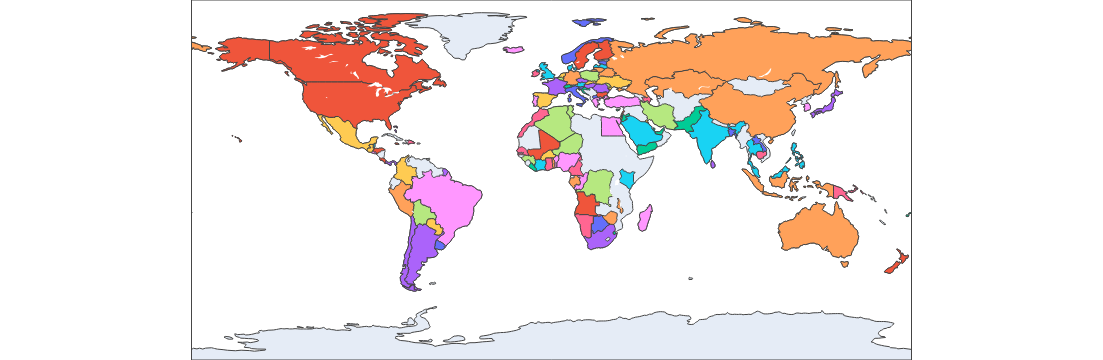

In [86]:
#adjustting how numbers are formated when viewing tool tips on the choropleth map
df_fdi_gdp_final['FDI net inflows (millions USD)']= \
df_fdi_gdp_final['Foreign direct investment, net inflows (BoP, current US$)'].map('${:,.2f}'.format)

df_fdi_gdp_final['FDI net outflows (millions USD)']= \
df_fdi_gdp_final['Foreign direct investment, net outflows (BoP, current US$)'].map('${:,.2f}'.format)

df_fdi_gdp_final['Real GDP (millions USD)']= \
df_fdi_gdp_final['GDP (constant 2015 US$)'].map('${:,.2f}'.format)

df_fdi_gdp_final['FDI net inflows (% of GDP)'] = \
df_fdi_gdp_final['Foreign direct investment, net inflows (% of GDP)'].apply('{:.2%}'.format)

df_fdi_gdp_final['FDI net outflows (% of GDP)'] = \
df_fdi_gdp_final['Foreign direct investment, net outflows (% of GDP)'].apply('{:.2%}'.format)

df_fdi_gdp_final['GDP growth'] = \
df_fdi_gdp_final['GDP growth (annual %)'].apply('{:.2%}'.format)

data= df_fdi_gdp_final[df_fdi_gdp_final['Year']==2022]

#plotting choropleth map
fig=px.choropleth(data,
                  locations='Country Code', 
                  locationmode='ISO-3',
                  color='FDI net inflows (millions USD)',
                  hover_name='Country', 
                  hover_data=['FDI net inflows (% of GDP)',
                              'FDI net outflows (millions USD)',
                              'FDI net outflows (% of GDP)',
                              'Real GDP (millions USD)',
                              'GDP growth'],
                  color_continuous_scale='Viridis', 
                  scope='world')

fig.update_traces(showlegend=False)      

fig.update_layout(dragmode=False,
                  plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  margin=dict(l=0, r=0, t=0, b=0))


fig.show()


**Global FDI data and GDP data for 2022**

If you’re viewing this in a Jupyter Notebook, you have the ability to hover over countries and access detailed statistics

In [89]:
df_fdi_gdp_final.drop(columns=['FDI net inflows (% of GDP)',
                               'FDI net outflows (millions USD)',
                               'FDI net inflows (millions USD)',
                               'FDI net outflows (% of GDP)',
                               'Real GDP (millions USD)',
                               'GDP growth'],
                      inplace=True)

In [90]:
df_fdi_gdp_final

Country Code   Country                     region          incomeLevel  \
0             ABW     Aruba  Latin America & Caribbean          High income   
1             ABW     Aruba  Latin America & Caribbean          High income   
2             ABW     Aruba  Latin America & Caribbean          High income   
3             ABW     Aruba  Latin America & Caribbean          High income   
4             ABW     Aruba  Latin America & Caribbean          High income   
...           ...       ...                        ...                  ...   
6722          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6723          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6724          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6725          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   
6726          ZWE  Zimbabwe         Sub-Saharan Africa  Lower middle income   

      Year  Foreign direct investment, net (BoP, current US$)  \
0     1992                                             36.983   
1     1993                                             17.933   
2     1994                                             73.184   
3     1995                                              5.531   
4     1996                                            -84.134   
...    ...                                                ...   
6722  2018                                           -717.079   
6723  2019                                           -247.096   
6724  2020                                           -153.860   
6725  2021                                           -218.000   
6726  2022                                           -336.800   

      Foreign direct investment, net inflows (% of GDP)  \
0                                                -3.858   
1                                                -1.655   
2                                                -5.874   
3                                                -0.419   
4                                                 6.162   
...                                                 ...   
6722                                              2.102   
6723                                              1.143   
6724                                              0.699   
6725                                              0.881   
6726                                              1.444   

      Foreign direct investment, net inflows (BoP, current US$)  \
0                                               -36.983           
1                                               -17.933           
2                                               -73.184           
3                                                -5.531           
4                                                85.028           
...                                                 ...           
6722                                            717.865           
6723                                            249.500           
6724                                            150.360           
6725                                            250.000           
6726                                            395.100           

      Foreign direct investment, net outflows (% of GDP)  \
0                                                 1.037    
1                                                 0.634    
2                                                 0.121    
3                                                 0.127    
4                                                 0.065    
...                                                 ...    
6722                                              0.002    
6723                                              0.011    
6724                                             -0.016    
6725                                              0.113    
6726                                              0.213    

      Foreign direct investment, net out

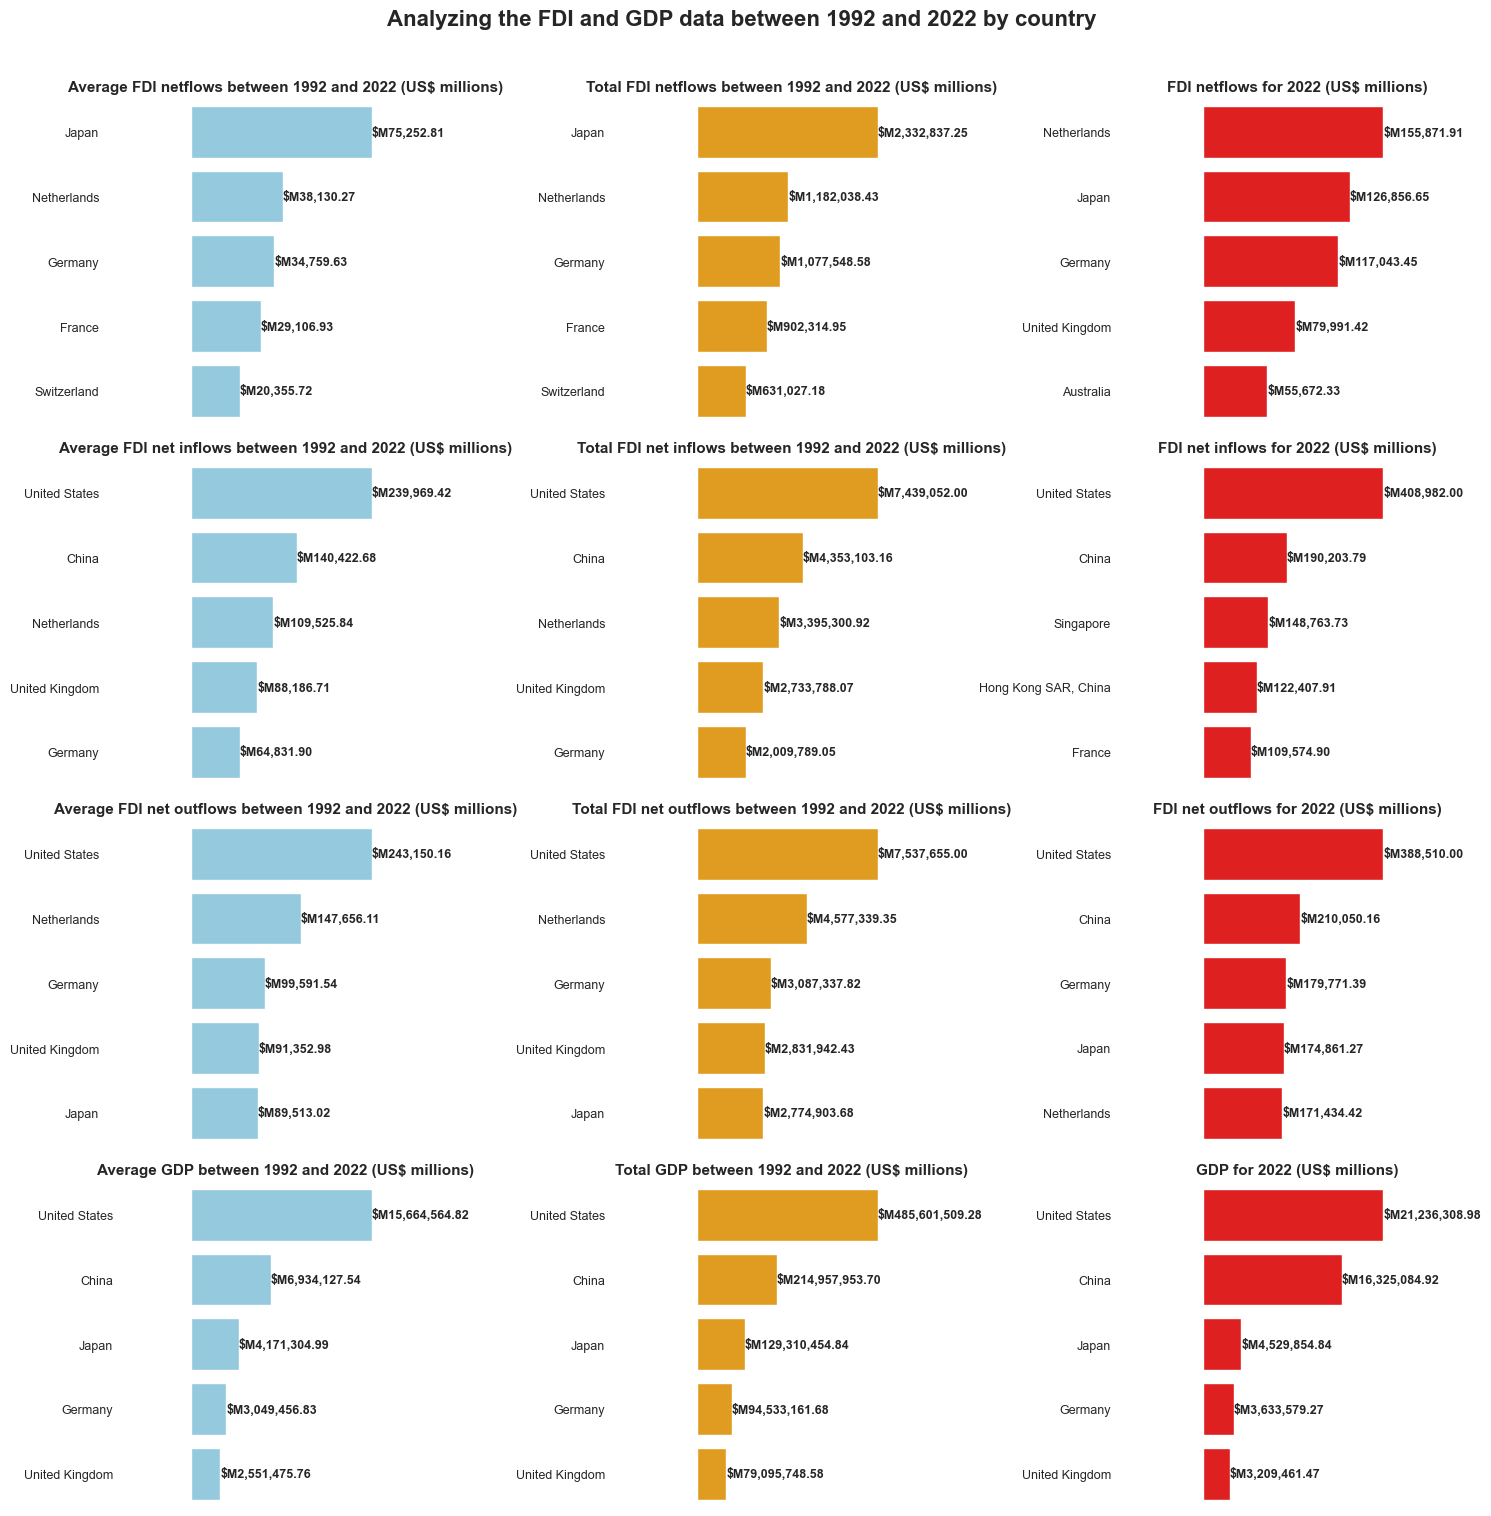

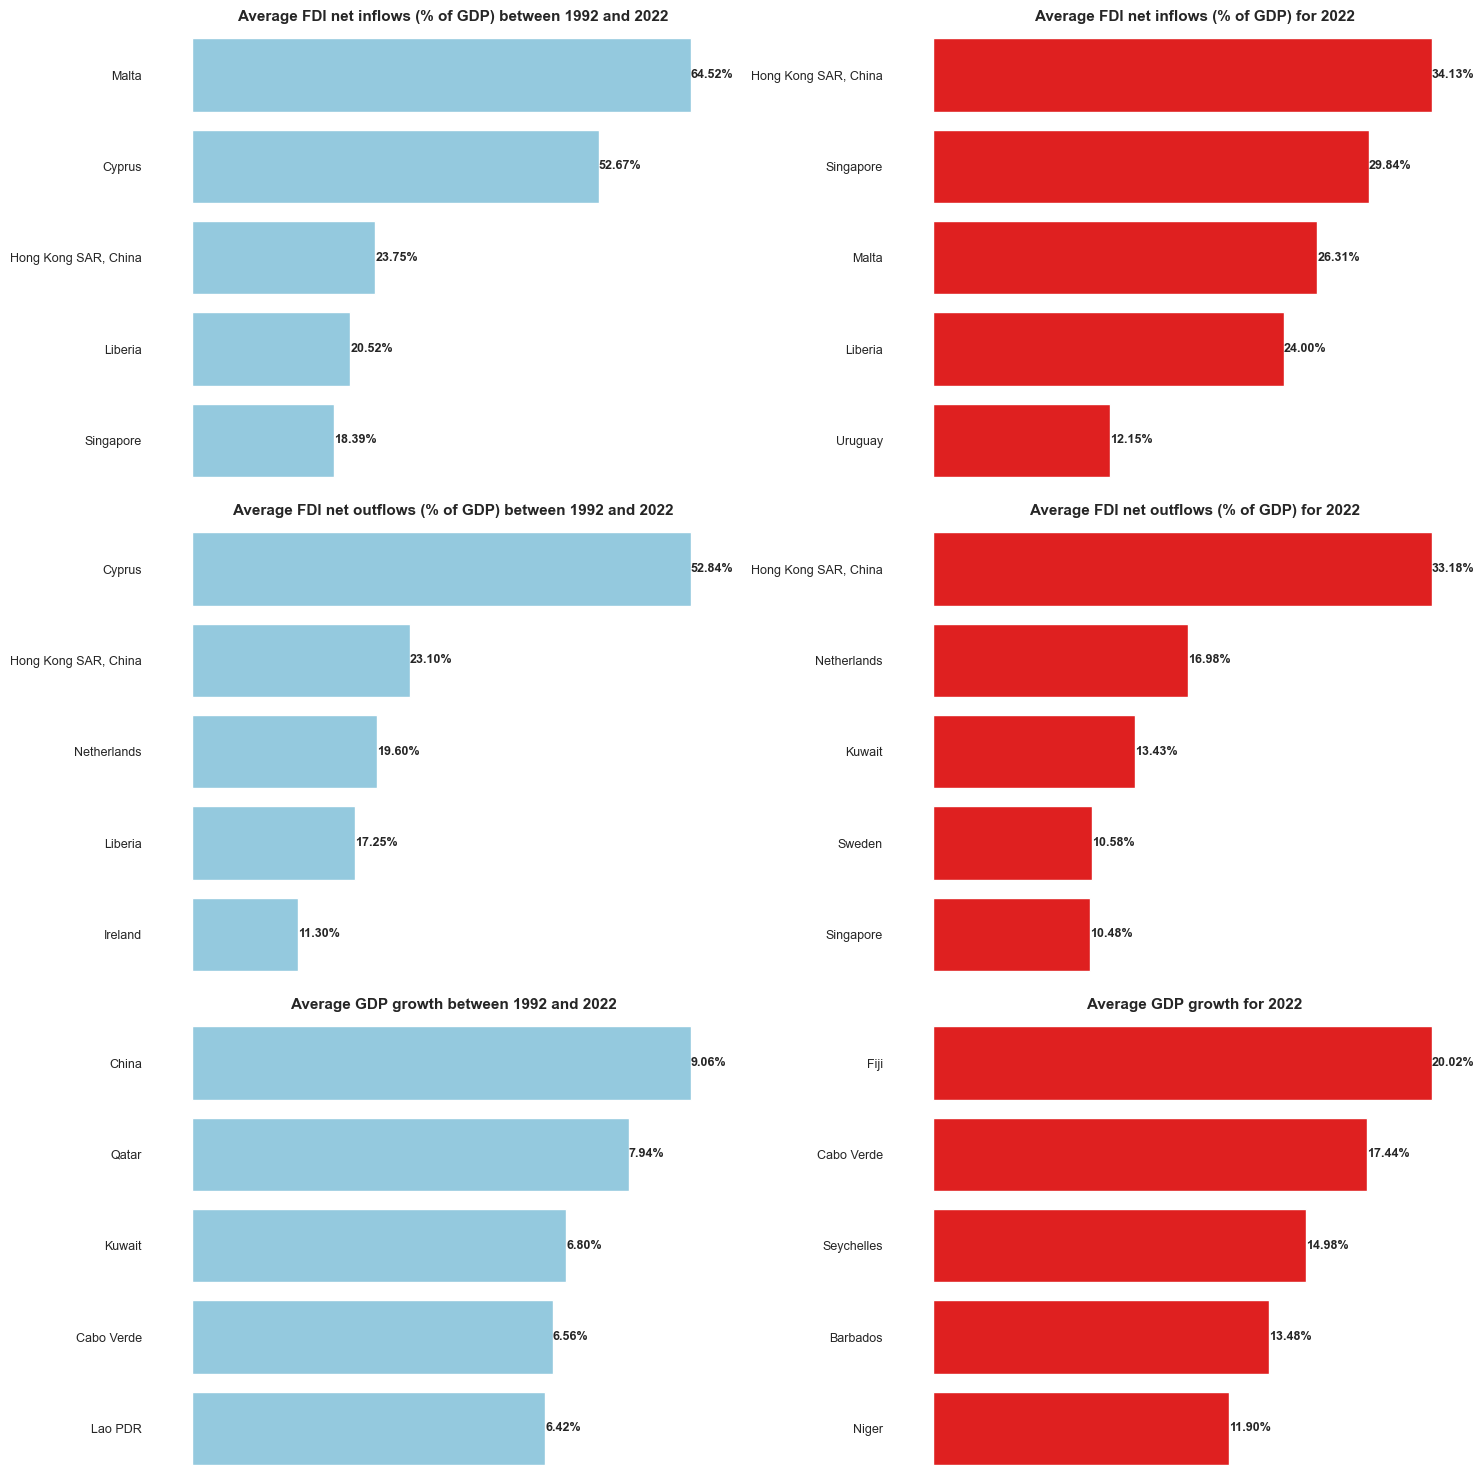

In [91]:

#dataframe that aggregates countries by mean
country_fdi_mean=df_fdi_gdp_final.drop(columns=['Country Code','incomeLevel','region']).groupby('Country').mean().reset_index().round(2)

#dataframe that aggregates countries by sum
country_fdi_sum=df_fdi_gdp_final.drop(columns=['Country Code','incomeLevel','region']).groupby('Country').sum().reset_index().round(2)

#dataframe that aggregates countries by year 2022
country_fdi_2022=df_fdi_gdp_final[df_fdi_gdp_final['Year']==2022].drop(columns=['Country Code','incomeLevel','region']).groupby('Country').mean().reset_index().round(2)

#dataframes that sort values by variables - mean
top5_fdi_in_mean = country_fdi_mean.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)',ascending=False).iloc[:5]
top5_fdi_in_pctGDP_mean = country_fdi_mean.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False).iloc[:5]
top5_fdi_out_mean = country_fdi_mean.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False).iloc[:5]
top5_fdi_out_pctGDP_mean = country_fdi_mean.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False).iloc[:5]
top5_gdp_mean = country_fdi_mean.sort_values(by='GDP (constant 2015 US$)', ascending=False).iloc[:5]
top5_gdp_growth_mean = country_fdi_mean.sort_values(by='GDP growth (annual %)', ascending=False).iloc[:5]
top5_fdi_net_mean = country_fdi_mean.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False).iloc[:5]

#dataframes that sort values by variables - sum
top5_fdi_in_sum = country_fdi_sum.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)',ascending=False).iloc[:5]
top5_fdi_in_pctGDP_sum = country_fdi_sum.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False).iloc[:5]
top5_fdi_out_sum = country_fdi_sum.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False).iloc[:5]
top5_fdi_out_pctGDP_sum = country_fdi_sum.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False).iloc[:5]
top5_gdp_sum = country_fdi_sum.sort_values(by='GDP (constant 2015 US$)', ascending=False).iloc[:5]
top5_fdi_net_sum = country_fdi_sum.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False).iloc[:5]

#dataframes that sort values by variables - 2022
top5_fdi_in_2022 = country_fdi_2022.sort_values(by='Foreign direct investment, net inflows (BoP, current US$)',ascending=False).iloc[:5]
top5_fdi_in_pctGDP_2022 = country_fdi_2022.sort_values(by='Foreign direct investment, net inflows (% of GDP)', ascending=False).iloc[:5]
top5_fdi_out_2022 = country_fdi_2022.sort_values(by='Foreign direct investment, net outflows (BoP, current US$)', ascending=False).iloc[:5]
top5_fdi_out_pctGDP_2022 = country_fdi_2022.sort_values(by='Foreign direct investment, net outflows (% of GDP)', ascending=False).iloc[:5]
top5_gdp_2022 = country_fdi_2022.sort_values(by='GDP (constant 2015 US$)', ascending=False).iloc[:5]
top5_gdp_growth_2022 = country_fdi_2022.sort_values(by='GDP growth (annual %)', ascending=False).iloc[:5]
top5_fdi_net_2022 = country_fdi_2022.sort_values(by='Foreign direct investment, net (BoP, current US$)', ascending=False).iloc[:5]

#calling barchart function
barcharts(top5_fdi_net_mean,top5_fdi_net_sum,top5_fdi_net_2022,
          top5_fdi_in_mean,top5_fdi_in_sum,top5_fdi_in_2022, 
          top5_fdi_out_mean, top5_fdi_out_sum, top5_fdi_out_2022, 
          top5_gdp_mean, top5_gdp_sum, top5_gdp_2022,
          top5_fdi_in_pctGDP_mean, top5_fdi_in_pctGDP_2022,
          top5_fdi_out_pctGDP_mean, top5_fdi_out_pctGDP_2022,
          top5_gdp_growth_mean, top5_gdp_growth_2022,
          'Country','country')

**Foreign Direct Investment (FDI) Insights**

**FDI Netflows (1992–2022):**

1. **Top 5 Countries (Average and Total Netflows):**
   - Japan, Germany, Netherlands, France, and Switzerland were the top countries for average and total FDI netflows between 1992 and 2020.
   - In 2022, Australia replaced Switzerland in the top 5.

2. **Aggregate FDI Inflow (1992–2022):**
   - The United States, China, Netherlands, United Kingdom, and Germany received the highest aggregate FDI inflows.
   - The United States led with a total of USD 7.4 trillion received over the period.
   - In 2022, the United States still received the most investment, totaling USD 388.1 billion.

3. **FDI Inflow as a % of GDP (31-year period):**
   - Malta, Cyprus, Hong Kong, Liberia, and Singapore relied heavily on FDI, with Malta and Cyprus averaging over 50% of GDP.
   - In 2022, Hong Kong led with 34.13%, while Singapore, Malta, Liberia, and Mauritania ranged between 14% and 30%.

**FDI Outflows (1992–2022):**

1. **Top 5 Countries (Total Outflows):**
   - The United States, Netherlands, Germany, United Kingdom, and Japan were the top FDI outflow countries.
   - The United States invested USD 7.6 trillion in other economies during this period.
   - In 2022, the United States had the highest outflows at USD 426.3 billion.

2. **Average FDI Outflow as a % of GDP (1992–2022):**
   - Cyprus led with 52.84%, followed by Hong Kong, Netherlands, Liberia, and Ireland (ranging from 11% to 24%).
   - In 2022, Hong Kong maintained its lead with 33.18%, followed by Kuwait, Netherlands, Singapore, and Sweden (10% to 13%).

**GDP Insights:**

1. **Largest Economies (31-year period):**
   - The United States and China had the highest aggregated GDP: USD 485.6 trillion and USD 215 trillion, respectively.
   - Japan, Germany, and the United Kingdom completed the top 5.

2. **Average GDP Growth (31-year period):**
   - China led with 9.06% average growth, followed by Qatar, Kuwait, Cabo Verde, and Lao PDR (6% to 8%).
   - In 2022, Fiji had the highest growth rate (20.02%), with Cabo Verde, Seychelles, Barbados, and Niger also showing strong growth (11% to 18%).

### Trend analysis

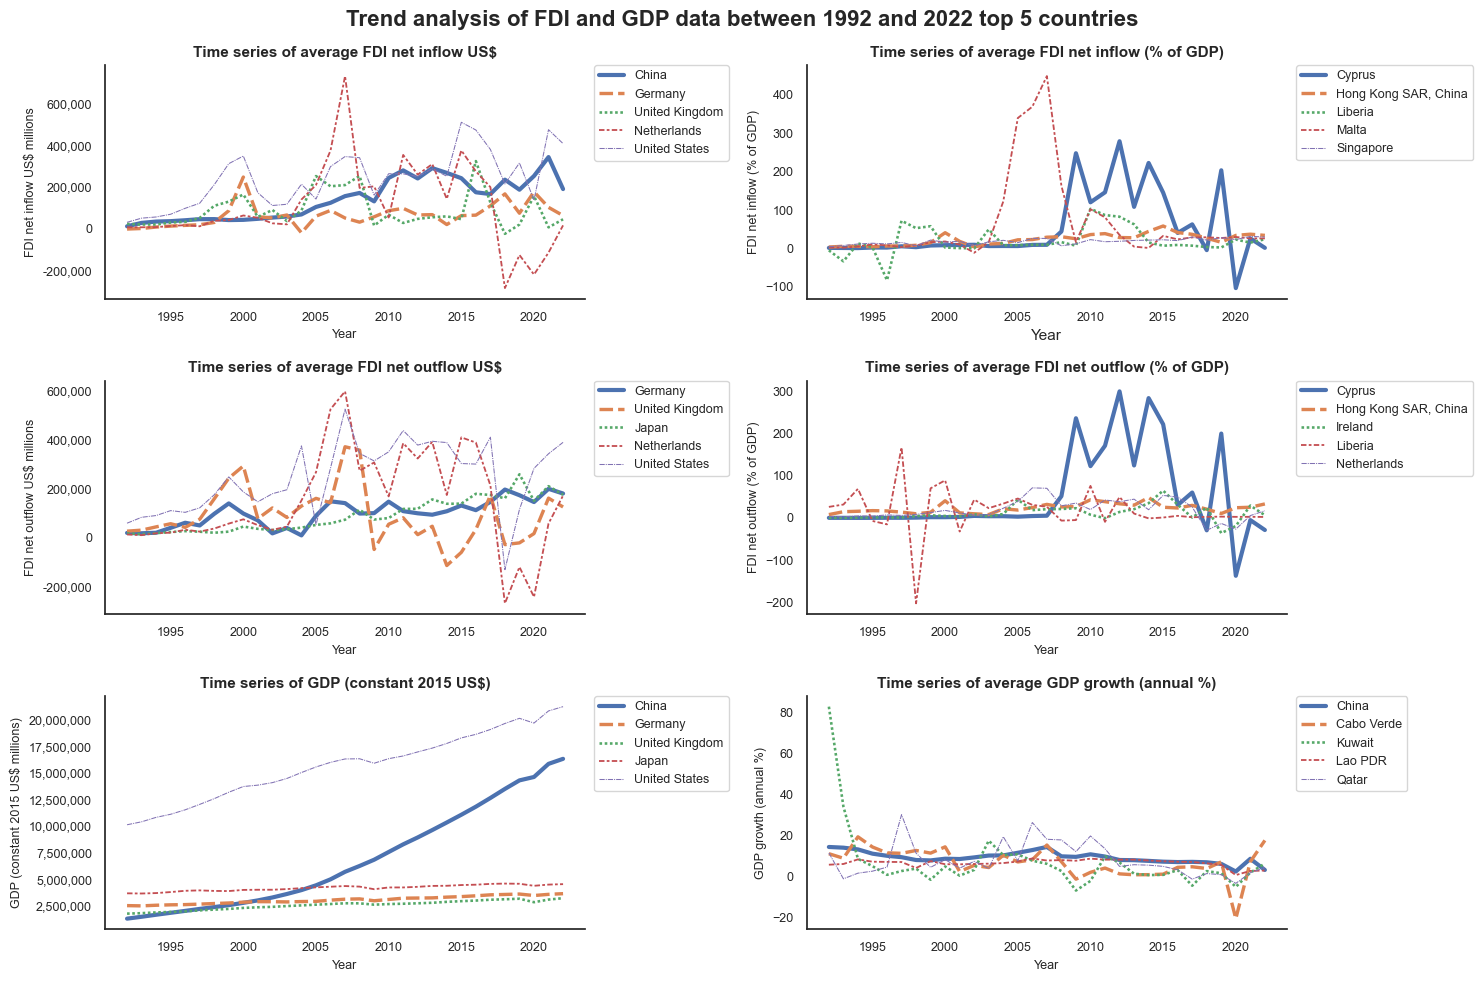

In [94]:
fig, ax = plt.subplots(nrows=3,ncols=2, figsize= (15,10))
    
#1plotting line chart average fdi inflow US$ trend
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_fdi_in_mean['Country'].values))], 
             x='Year', 
             y='Foreign direct investment, net inflows (BoP, current US$)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[0,0])
#setting title
ax[0,0].set_title('Time series of average FDI net inflow US$',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[0,0].set_xlabel('Year', 
                   fontsize=9)
ax[0,0].set_ylabel('FDI net inflow US$ millions', 
                   fontsize=9)
ax[0,0].tick_params(axis='x', 
                    labelsize=9)
ax[0,0].tick_params(axis='y', 
                    labelsize=9)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)
ax[0,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


#2plotting line chart average FDI % of GDP
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_fdi_in_pctGDP_mean['Country'].values))], 
             x='Year', 
             y='Foreign direct investment, net inflows (% of GDP)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[0,1])
#setting title
ax[0,1].set_title('Time series of average FDI net inflow (% of GDP)',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[0,1].set_xlabel('Year', 
                   fontsize=11)
ax[0,1].set_ylabel('FDI net inflow (% of GDP)', 
                   fontsize=9)
ax[0,1].tick_params(axis='x', 
                    labelsize=9)
ax[0,1].tick_params(axis='y', 
                    labelsize=9)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)

#3plotting line chart average fdi outflow US$ trend
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_fdi_out_mean['Country'].values))], 
             x='Year', 
             y='Foreign direct investment, net outflows (BoP, current US$)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[1,0])
#setting title
ax[1,0].set_title('Time series of average FDI net outflow US$',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[1,0].set_xlabel('Year', 
                   fontsize=9)
ax[1,0].set_ylabel('FDI net outflow US$ millions', 
                   fontsize=9)
ax[1,0].tick_params(axis='x', 
                    labelsize=9)
ax[1,0].tick_params(axis='y', 
                    labelsize=9)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)
ax[1,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#4plotting line chart average FDI % of GDP
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_fdi_out_pctGDP_mean['Country'].values))], 
             x='Year', 
             y='Foreign direct investment, net outflows (% of GDP)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[1,1])
#setting title
ax[1,1].set_title('Time series of average FDI net outflow (% of GDP)',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[1,1].set_xlabel('Year', 
                   fontsize=9)
ax[1,1].set_ylabel('FDI net outflow (% of GDP)', 
                   fontsize=9)
ax[1,1].tick_params(axis='x', 
                    labelsize=9)
ax[1,1].tick_params(axis='y', 
                    labelsize=9)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)

#5plotting line chart average GDP US$ trend
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_gdp_mean['Country'].values))], 
             x='Year', 
             y='GDP (constant 2015 US$)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[2,0])
#setting title
ax[2,0].set_title('Time series of GDP (constant 2015 US$)',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[2,0].set_xlabel('Year', 
                   fontsize=9)
ax[2,0].set_ylabel('GDP (constant 2015 US$ millions)', 
                   fontsize=9)
ax[2,0].tick_params(axis='x', 
                    labelsize=9)
ax[2,0].tick_params(axis='y', 
                    labelsize=9)
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)
ax[2,0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

#6plotting line chart average GDP growth trend
sns.lineplot(data=df_fdi_gdp_final[df_fdi_gdp_final['Country'].isin(list(top5_gdp_growth_mean['Country'].values))], 
             x='Year', 
             y='GDP growth (annual %)',
             hue='Country',
             ci=None, 
             style='Country',
             size='Country',
             ax=ax[2,1])
#setting title
ax[2,1].set_title('Time series of average GDP growth (annual %)',
                  fontweight='bold',
                  fontsize=11,
                  wrap=True)
#adjusting axis labels and ticks
ax[2,1].set_xlabel('Year', 
                   fontsize=9)
ax[2,1].set_ylabel('GDP growth (annual %)', 
                   fontsize=9)
ax[2,1].tick_params(axis='x', 
                    labelsize=9)
ax[2,1].tick_params(axis='y', 
                    labelsize=9)
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].legend(bbox_to_anchor=(1.02, 1),
               loc='upper left', 
               borderaxespad=0,
               fontsize=9)

#main title
plt.suptitle('Trend analysis of FDI and GDP data between 1992 and 2022 top 5 countries', 
             fontsize=16, 
             fontweight='bold')

#adjusting subplot spacing
plt.tight_layout()

**Summary of visuals**

1. **FDI Inflows and Outflows:**
   - The top 5 countries exhibit no consistent trend in FDI inflows and outflows.
   - Fluctuations occur throughout the entire period, suggesting a lack of steady patterns.

2. **GDP Trends:**
   - The United States and China show a robust upward trend in GDP over time.
   - However, for Germany, Japan, and the United Kingdom, GDP remains relatively flat without significant growth.

3. **GDP Growth:**
   - Across all top 5 countries, GDP growth follows a similar trajectory.
   - Minor fluctuations occur, but the overall trend remains consistent.

In summary, while FDI experiences volatility, GDP growth maintains stability across these nations.

### Share of global GDP

In [97]:
#creating a new column that shows percentage share of FDI inflow
country_fdi_sum['Percentage of average FDI inflow'] = \
country_fdi_sum['Foreign direct investment, net inflows (BoP, current US$)']\
.apply(lambda x: (x / country_fdi_sum['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

country_fdi_2022['Percentage of average FDI inflow'] = \
country_fdi_2022['Foreign direct investment, net inflows (BoP, current US$)']\
.apply(lambda x: (x / country_fdi_2022['Foreign direct investment, net inflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)


#creating a new column that shows percentage share of FDI outflow
country_fdi_sum['Percentage of average FDI outflow'] = \
country_fdi_sum['Foreign direct investment, net outflows (BoP, current US$)']\
.apply(lambda x: (x / country_fdi_sum['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

country_fdi_2022['Percentage of average FDI outflow'] = \
country_fdi_2022['Foreign direct investment, net outflows (BoP, current US$)']\
.apply(lambda x: (x / country_fdi_2022['Foreign direct investment, net outflows (BoP, current US$)']\
                  .sum()) * 100)\
.round(2)

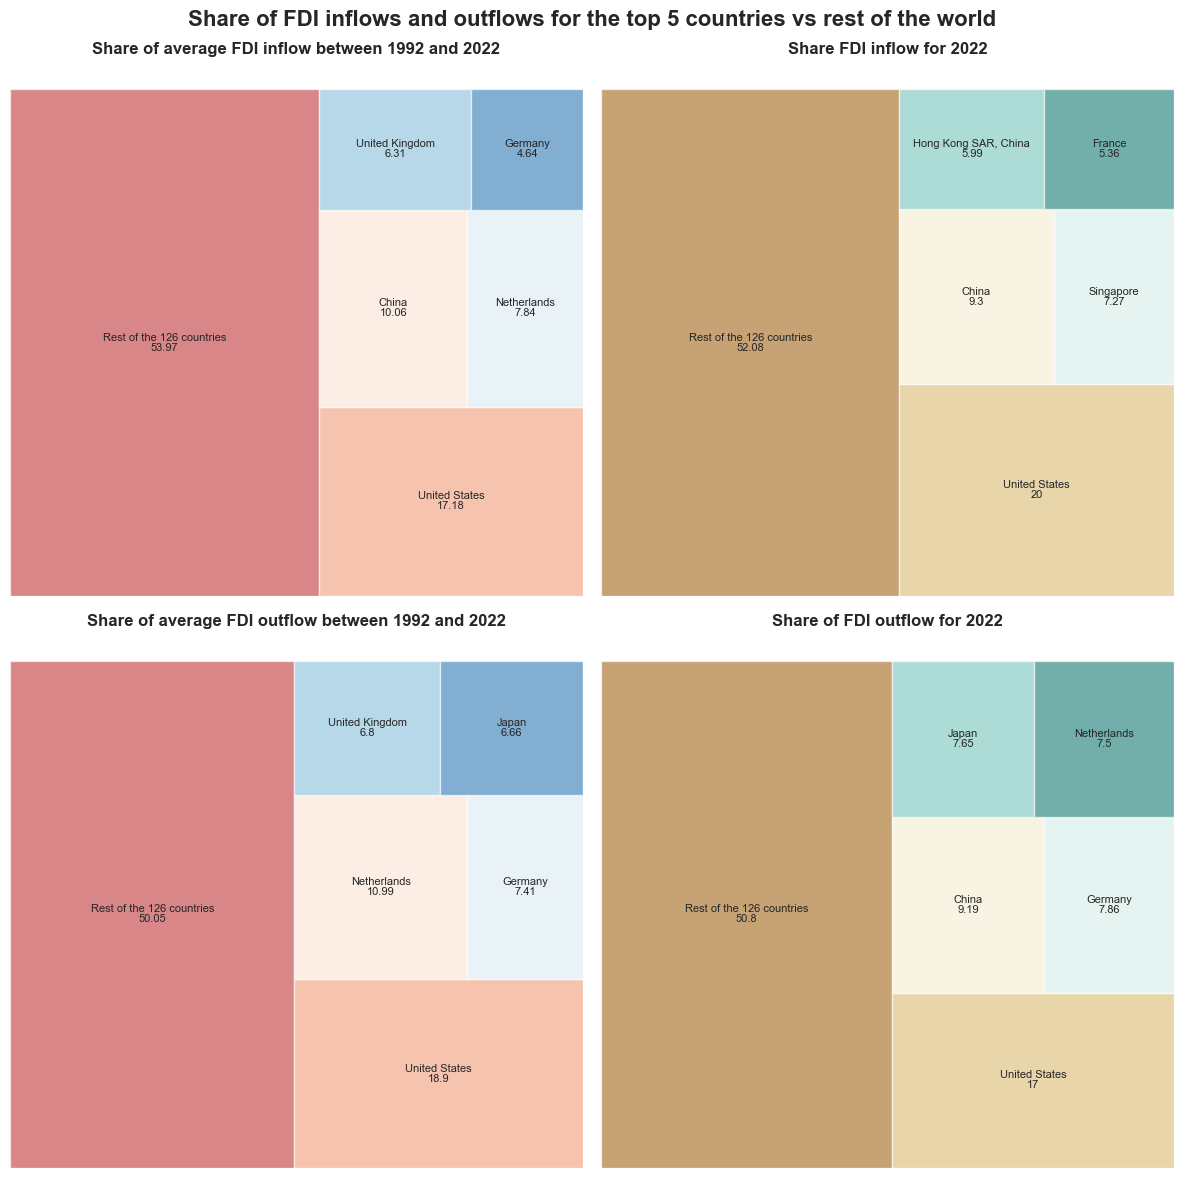

In [98]:
#creating the list of labels and values
label_in_avg = ['Rest of the 126 countries','United States', 'China','Netherlands', 'United Kingdom', 'Germany']
label_in_2022=['Rest of the 126 countries','United States', 'China','Singapore', 'Hong Kong SAR, China','France']
label_out_avg=['Rest of the 126 countries','United States', 'Netherlands', 'Germany', 'United Kingdom','Japan']
label_out_2022=['Rest of the 126 countries','United States', 'China', 'Germany','Japan','Netherlands']
values_in_avg=[53.97,17.18,10.06,7.84,6.31,4.64]
values_in_2022=[52.08,20,9.3,7.27,5.99,5.36]
values_out_avg= [50.05,18.90,10.99,7.41,6.80,6.66]
values_out_2022= [50.8,17,9.19,7.86,7.65,7.50]


#plotting treemaps
fig, ax = plt.subplots(2,2, figsize=(12,12))
squarify.plot(sizes=values_in_avg,
              label=label_in_avg, 
              alpha=.6, 
              text_kwargs={'fontsize':8,
                           'wrap':True}, 
              value=values_in_avg,
              color=sns.color_palette('RdBu'), 
              ax=ax[0,0])

squarify.plot(sizes=values_in_2022,
              label=label_in_2022, 
              alpha=.6, 
              text_kwargs={'fontsize':8,
                           'wrap':True}, 
              value=values_in_2022,
              color=sns.color_palette('BrBG'), 
              ax=ax[0,1])

squarify.plot(sizes=values_out_avg,
              label=label_out_avg, 
              alpha=.6, 
              text_kwargs={'fontsize':8,
                           'wrap':True}, 
              value=values_out_avg,
              color=sns.color_palette('RdBu'), 
              ax=ax[1,0])

squarify.plot(sizes=values_out_2022,
              label=label_out_2022, 
              alpha=.6, 
              text_kwargs={'fontsize':8,
                           'wrap':True}, 
              value=values_out_2022,
              color=sns.color_palette('BrBG'), 
              ax=ax[1,1])

#setting titles
ax[0,0].set_title('Share of average FDI inflow between 1992 and 2022', 
              fontsize=12, 
              fontweight='bold', 
              pad=25)
ax[0,1].set_title('Share FDI inflow for 2022',
              fontsize=12, 
              fontweight='bold',
              pad=25)

ax[1,0].set_title('Share of average FDI outflow between 1992 and 2022', 
              fontsize=12, 
              fontweight='bold', 
              pad=25),
ax[1,1].set_title('Share of FDI outflow for 2022',
              fontsize=12, 
              fontweight='bold',
              pad=25)

#removing axis values
ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")

#setting main title
plt.suptitle('Share of FDI inflows and outflows for the top 5 countries vs rest of the world', 
         fontsize=16, 
         fontweight='bold')

#adjusting subplot spacing
fig.tight_layout()

**Global FDI Inflows:**

- **Average Over 31 Years:**
  - The United States held the largest share of global FDI inflows, with 17.18%.
  - China followed with 10.06%, and the Netherlands with 7.84%.
  - The United Kingdom and Germany contributed just over 6.31% and 4.64%, respectively.
  - Other countries in the dataset collectively accounted for 53.97% of FDI inflows.

- **2022:**
  - In 2022, the United States maintained its lead, capturing 20% of FDI inflows.
  - China and Singapore ranked second and third, with 9.3% and 7.27%, respectively.
  - Hong Kong and France each had over 5% shares.
  - The remaining countries shared 52.08% of FDI inflows.

**Global FDI Outflows:**

- **Overall (1922–2022):**
  - The United States continued to lead in global FDI outflows, with an 18.9% share.
  - The Netherlands and Germany followed closely, contributing 10.99% and 7.41%, respectively.
  - The United Kingdom and Japan both had slightly over 6% shares.
  - Other countries collectively represented just over 50% of FDI outflows.

- **2022:**
  - In 2022, the United States remained at the forefront with a 17% share.
  - China and Germany secured second and third positions, with 9.19% and 7.86%, respectively.
  - Japan and the Netherlands each contributed just over 7%.

# Granger causality test


## What is the granger causality test

The Granger causality test examines whether one time series can serve as a predictor for another. Specifically in this project, we aim to explore whether FDI inflows can predict economic growth (GDP).

Here's how the test works:

1. **Models Comparison**:
   - We compare two models:
     - Model 1 includes only lagged values of GDP growth (Y).
     - Model 2 incorporates both lagged GDP growth (Y) and FDI inflows (X).
   - If Model 2 fits better and X's lag coefficients are significant, we say that X Granger causes Y.

2. **Implications**:
   - If X Granger-causes Y, it means that FDI provides valuable information for forecasting GDP growth.
   - Keep in mind that Granger causality doesn't prove true causation but identifies predictive relationships.

In summary, this test helps us understand whether FDI data can enhance our ability to forecast economic growth.

## Removing outliers 

In [104]:
#Removing outliers using the interquatile range
def outliers(df, feature):
    Q1= df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = outliers(df_fdi_gdp_final, 'Foreign direct investment, net inflows (BoP, current US$)')
print("Upper whisker: ", upper)
print("Lower Whisker: ", lower)

Upper whisker:  13622.339360464233
Lower Whisker:  -7962.490933205908


In [105]:
#removing outliers
df_fdi_gdp_final_no_outliers = df_fdi_gdp_final[(df_fdi_gdp_final['Foreign direct investment, net inflows (BoP, current US$)'] > lower) & \
                                                (df_fdi_gdp_final['Foreign direct investment, net inflows (BoP, current US$)'] < upper)]
print('Number of records before outliers are removed:' + str(len(df_fdi_gdp_final)))
print('Number of records after outliers are removed:' + str(len(df_fdi_gdp_final_no_outliers))) 


Number of records before outliers are removed:3875
Number of records after outliers are removed:3238


## Stating hypothesis

H0: The times series of FDI inflows does not Granger-cause the time series of economic growth

H1: The times series of FDI inflows does Granger cause the time series of economic growth

**Level of significance 5%**

## Statistical test

In [109]:
grangercausalitytests(df_fdi_gdp_final_no_outliers[['GDP growth (annual %)', 
                                                    'Foreign direct investment, net inflows (BoP, current US$)']],
                      maxlag=4, 
                      verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8904  , p=0.0153  , df_denom=3234, df_num=1
ssr based chi2 test:   chi2=5.8958  , p=0.0152  , df=1
likelihood ratio test: chi2=5.8905  , p=0.0152  , df=1
parameter F test:         F=5.8904  , p=0.0153  , df_denom=3234, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1639  , p=0.0156  , df_denom=3231, df_num=2
ssr based chi2 test:   chi2=8.3407  , p=0.0154  , df=2
likelihood ratio test: chi2=8.3300  , p=0.0155  , df=2
parameter F test:         F=4.1639  , p=0.0156  , df_denom=3231, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9525  , p=0.0314  , df_denom=3228, df_num=3
ssr based chi2 test:   chi2=8.8767  , p=0.0310  , df=3
likelihood ratio test: chi2=8.8645  , p=0.0311  , df=3
parameter F test:         F=2.9525  , p=0.0314  , df_denom=3228, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2835  , p=0.

{1: ({'ssr_ftest': (5.890361760294195, 0.01527825407132814, 3234.0, 1),
   'ssr_chi2test': (5.895825917771276, 0.015176810585353681, 1),
   'lrtest': (5.8904631416953634, 0.015223096227494185, 1),
   'params_ftest': (5.8903617602944625, 0.015278254071318505, 3234.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.163924882321564, 0.015629926122182714, 3231.0, 2),
   'ssr_chi2test': (8.340737183034713, 0.015446565601444657, 2),
   'lrtest': (8.330006560769107, 0.015529663956752189, 2),
   'params_ftest': (4.1639248823182555, 0.015629926122230638, 3231.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.952482255900472, 0.031400274072356515, 3228.0, 3),
   'ssr_chi2test': (8.876654366020473, 0.030976591043353055, 3),
   'lrtest': (8.864498083265062, 0.031147776210638755, 3),
   'params_ftest': (2.952482255887944, 0.03140027407288288, 3228.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
    

## Conclusion



1. **Lag 1**:
   - The p-value of 0.0135 is less than 0.05.
   - FDI inflows Granger-cause GDP growth with a one-period delay.

2. **Lag 2**:
   - The p-value remains significant at 0.0212.
   - FDI inflows continue to Granger-cause GDP growth with a two-period delay.

3. **Lag 3**:
   - The p-value stands at 0.043, still below 0.05.
   - FDI inflows Granger-cause GDP growth with a three-period delay.

Remember that Granger causality identifies predictive relationships but doesn't imply true causation.

Recognizing how FDI contributes to a country’s economic growth enables governments to formulate effective policies. These may include measures to enhance the ease of doing business, invest in modern infrastructure (such as road networks and telecommunications), and maintain a stable political environment.
